# Libraries

In [1]:
import os
import pandas as pd
import numpy as np
from IPython.display import display, HTML
import matplotlib.pyplot as plt
import seaborn as sns
import re

# Color Palete

In [2]:
# Create 'Blues' color palette
colors = sns.color_palette('Blues', n_colors=20)[5:]  # Skip lightest 5 colors

# Functions

## Clean CPV codes

In [3]:
def clean_codes(x):
    if isinstance(x, np.ndarray):
        return [str(code).strip() for code in x.tolist()]
    elif isinstance(x, list):
        return [str(code).strip() for code in x]
    elif isinstance(x, str):
        # In case there's a string that looks like a list
        return [x.strip()]
    else:
        return []

## Count null and empty

In [4]:
def count_null_and_empty(df, column_name):
    total = len(df)

    # Count NaN (null) values
    null_count = df[column_name].isna().sum()
    null_pct = (null_count / total) * 100

    # Count empty string values (after stripping whitespace)
    empty_count = (df[column_name].astype(str).str.strip() == '').sum()
    empty_pct = (empty_count / total) * 100

    # Print results
    print(f"Null (NaN) values: {null_count} ({null_pct:.2f}%)")
    print(f"Empty string values: {empty_count} ({empty_pct:.2f}%)")

## print top n

In [5]:
def print_top_n(df, column_name, top_n=20):
    if column_name not in df.columns:
        print(f"Column '{column_name}' not found in the DataFrame.")
        return
    
    # Calculate the top 'n' most frequent values
    top_n_values = df[column_name].value_counts().head(top_n)
    
    # Print the top 'n' values
    print(f"Top {top_n} most frequent values for '{column_name}':")
    print(top_n_values)

## print bottom n

In [6]:
def print_bottom_n(df, column_name, bottom_n=20):
    if column_name not in df.columns:
        print(f"Column '{column_name}' not found in the DataFrame.")
        return

    # Calculate value counts and get the bottom 'n' values
    bottom_n_values = df[column_name].value_counts().sort_values(ascending=True).head(bottom_n)

    # Print the bottom 'n' values
    print(f"Bottom {bottom_n} least frequent values for '{column_name}':")
    print(bottom_n_values)

## print top n sorted

In [7]:
def print_top_n_sorted(df, column_name, top_n=20):
    if column_name not in df.columns:
        print(f"Column '{column_name}' not found in the DataFrame.")
        return

    # Get top N frequent values
    top_n_values = df[column_name].value_counts().head(top_n)

    # Sort the top N by the actual values (index)
    top_n_sorted = top_n_values.sort_index()

    print(f"Top {top_n} most frequent values for '{column_name}' (sorted by value):")
    print(top_n_sorted)

## print top n list

In [8]:
def print_top_n_list(df, column_name, top_n=20):
    if column_name not in df.columns:
        print(f"Column '{column_name}' not found in the DataFrame.")
        return

    # Explode the lists into separate rows
    exploded = df[column_name].explode()
    
    # Calculate the top 'n' most frequent individual values
    top_n_values = exploded.value_counts().head(top_n)

    # Print the results
    print(f"Top {top_n} most frequent values for '{column_name}':")
    print(top_n_values)

## plot top n list

In [9]:
def plot_top_n_list(df, column_name, top_n=20):
    if column_name not in df.columns:
        print(f"Column '{column_name}' not found in the DataFrame.")
        return

    # Explode the column if it contains lists
    exploded = df[column_name].explode()

    # Get the top 'n' most frequent values
    top_n_values = exploded.value_counts().head(top_n)

    # Plotting
    plt.figure(figsize=(10, 6))
    ax = sns.barplot(
        x=top_n_values.values,
        y=top_n_values.index,
        palette=colors,
        hue=top_n_values.index,
        legend=False
    )

    # Add value labels on the bars
    for i, value in enumerate(top_n_values.values):
        ax.text(value + max(top_n_values.values) * 0.01, i, str(value), va='center')

    plt.title(f"Top {top_n} Most Frequent Values for '{column_name}'", fontsize=16)
    plt.xlabel('Frequency', fontsize=12)
    plt.ylabel(column_name, fontsize=12)
    plt.tight_layout()
    plt.show()

## plot top n sorted with counts

In [10]:
def plot_top_n_sorted_with_counts(df, column_name, top_n=20):
    if column_name not in df.columns:
        print(f"Column '{column_name}' not found in the DataFrame.")
        return
    # Get top N frequent values
    top_n_values = df[column_name].value_counts().head(top_n)
    # Sort the top N by value (index)
    top_n_sorted = top_n_values.sort_index()
    # Plot
    plt.figure(figsize=(10, 6))
    ax = top_n_sorted.plot(kind='bar', color=colors)
    # Add count labels above bars
    for i, count in enumerate(top_n_sorted.values):
        ax.text(i, count + 0.5, str(count), ha='center', va='bottom', fontsize=10)
    plt.title(f"Top {top_n} most frequent values in '{column_name}' (sorted by value)")
    plt.xlabel(column_name)
    plt.ylabel("Frequency")
    plt.xticks(rotation=45)
    plt.grid(axis='y', linestyle='--', alpha=0.7)
    plt.tight_layout()
    plt.show()

## plot horizontal bar

In [11]:
def plot_horizontal_bar(count_series, title, xlabel, ylabel):
    plt.figure(figsize=(10, 6))
    bars = plt.barh(count_series.index.astype(str), count_series.values, color='skyblue')

    # Add annotations to each bar
    for bar in bars:
        width = bar.get_width()
        plt.text(width + max(count_series.values) * 0.01, bar.get_y() + bar.get_height() / 2,
                 f'{int(width)}', va='center', fontsize=9)

    plt.title(title)
    plt.xlabel(xlabel)
    plt.ylabel(ylabel)
    plt.xticks(rotation=45)
    plt.tight_layout()
    plt.show()

## plot grouped horizontal bar

In [12]:
# Define a function to plot grouped horizontal bars for the three features
def plot_grouped_horizontal_bar(df_counts, title, xlabel, ylabel):
    fig, ax = plt.subplots(figsize=(12, 7))
    
    n_categories = len(df_counts)        # Number of intervals/categories on y-axis
    n_features = len(df_counts.columns)  # Number of features to plot
    bar_height = 0.2                     # Height of each individual bar
    
    y_pos = np.arange(n_categories)     # Y positions for groups
    
    # Calculate offsets to place bars side by side centered around the group position
    offsets = np.linspace(-bar_height*n_features/2, bar_height*n_features/2, n_features)
    
    colors_bars = sns.color_palette('Blues', n_colors=3)  # Colors for each feature
    
    # Plot each feature's bars, shifting by offsets to avoid overlap
    for i, col in enumerate(df_counts.columns):
        ax.barh(y_pos + offsets[i], df_counts[col], height=bar_height, label=col, color=colors_bars[i])
        
        # Add numeric labels to the right of each bar
        for y, val in zip(y_pos + offsets[i], df_counts[col]):
            ax.text(val + max(df_counts.max())*0.01, y, str(val), va='center', fontsize=9)
    
    # Set y-axis ticks and labels to intervals
    ax.set_yticks(y_pos)
    ax.set_yticklabels(df_counts.index)
    
    # Set axis labels and title
    ax.set_xlabel(xlabel)
    ax.set_ylabel(ylabel)
    ax.set_title(title)
    
    ax.legend()  # Show legend for features
    plt.tight_layout()
    plt.show()

## plot grouped horizontal bars for sum by year

In [13]:
# Function to plot grouped horizontal bars for sum by year
def plot_grouped_sum_horizontal_bar(df_sums, title, xlabel, ylabel):
    fig, ax = plt.subplots(figsize=(12, 8))
    
    n_years = len(df_sums)
    n_features = len(df_sums.columns)
    bar_height = 0.2
    y_pos = np.arange(n_years)
    
    # Offsets to shift bars for each feature
    offsets = np.linspace(-bar_height*n_features/2, bar_height*n_features/2, n_features)
    colors_bars = sns.color_palette('Blues', n_colors=3)
    
    for i, col in enumerate(df_sums.columns):
        ax.barh(y_pos + offsets[i], df_sums[col], height=bar_height, label=col, color=colors_bars[i])
        
        # Annotate bars with value (rounded to millions or thousands for readability)
        for y, val in zip(y_pos + offsets[i], df_sums[col]):
            if val > 1_000_000:
                label = f'{val/1_000_000:.1f}M'
            elif val > 1_000:
                label = f'{val/1_000:.1f}K'
            else:
                label = f'{val:.0f}'
            ax.text(val + max(df_sums.max())*0.005, y, label, va='center', fontsize=9)
    
    ax.set_yticks(y_pos)
    ax.set_yticklabels(df_sums.index.astype(str))
    ax.set_xlabel(xlabel)
    ax.set_ylabel(ylabel)
    ax.set_title(title)
    ax.legend()
    plt.tight_layout()
    plt.show()

# Dictionaries

In [14]:
bins = [-1.0, 0.0, 5000, 50000, 139000, 5350000, np.inf]
labels = ['zero', 'Up to 5,000 €', '5,001 € to 50,000 €', '50,001 € to 139,000 €',
          '139,001 € to 5,350,000 €', 'Above 5,350,000 €']

# Read Parquet Files

## Folders

In [15]:
folder_path_contracts = '19_DataAfterCleaning'
folder_path_cpv = '16_CPV'

## List all parquet files

In [16]:
print('Contracts Files')
parquet_files_contracts = [f for f in os.listdir(folder_path_contracts) if f.endswith('.parquet')]
for f in parquet_files_contracts:
    print(f)

print('\nCPV Files')
parquet_files_cpv = [f for f in os.listdir(folder_path_cpv) if f.endswith('TiposContrato_CPV_TED_V1.0_filtered.parquet')]
for f in parquet_files_cpv:
    print(f)

Contracts Files
csv_resultados_2015.parquet
csv_resultados_2016.parquet
csv_resultados_2017.parquet
csv_resultados_2018.parquet
csv_resultados_2019.parquet
csv_resultados_2020.parquet
csv_resultados_2021.parquet
csv_resultados_2022.parquet
csv_resultados_2023.parquet
csv_resultados_2024.parquet

CPV Files
TiposContrato_CPV_TED_V1.0_filtered.parquet


## Dictionaries with all parquet files

In [17]:
dataframes_contracts = {}
for file in parquet_files_contracts:
    file_path = os.path.join(folder_path_contracts, file)
    df = pd.read_parquet(file_path)
    dataframes_contracts[file] = df

dataframes_cpv = {}
for file in parquet_files_cpv:
    file_path = os.path.join(folder_path_cpv, file)
    df = pd.read_parquet(file_path)
    dataframes_cpv[file] = df

## Verify uploaded files

In [18]:
print("Arquivos carregados contratos:")
for i, name in enumerate(dataframes_contracts.keys(), start=1):
    print(f"{i}. {name}")

print("Arquivos carregados cpv:")
for i, name in enumerate(dataframes_cpv.keys(), start=1):
    print(f"{i}. {name}")

Arquivos carregados contratos:
1. csv_resultados_2015.parquet
2. csv_resultados_2016.parquet
3. csv_resultados_2017.parquet
4. csv_resultados_2018.parquet
5. csv_resultados_2019.parquet
6. csv_resultados_2020.parquet
7. csv_resultados_2021.parquet
8. csv_resultados_2022.parquet
9. csv_resultados_2023.parquet
10. csv_resultados_2024.parquet
Arquivos carregados cpv:
1. TiposContrato_CPV_TED_V1.0_filtered.parquet


# Aggregate parquet files

In [19]:
df_list_contracts = []
for filename, df in dataframes_contracts.items():
    df['Fonte_Arquivo'] = filename  # Adiciona coluna com o nome do ficheiro
    df_list_contracts.append(df)
df_geral_contratos = pd.concat(df_list_contracts, ignore_index=True)

df_geral_cpv_in = dataframes_cpv['TiposContrato_CPV_TED_V1.0_filtered.parquet']

In [20]:
pd.set_option('display.max_columns', None) 
display(df_geral_cpv_in.head(5))

,ID,Tipo de Contrato,CPV,Ativo,CPVcode,CPVdescription
0,7690,Aquisição de serviços,73000000-2 - Serviços de investigação e desenv...,1,73000000-2,Serviços de investigação e desenvolvimento e s...
1,7691,Aquisição de serviços,73100000-3 - Serviços de desenvolvimento exper...,1,73100000-3,Serviços de desenvolvimento experimental e de ...
2,7692,Aquisição de serviços,73110000-6 - Serviços de investigação,1,73110000-6,Serviços de investigação
3,7693,Aquisição de serviços,73111000-3 - Serviços relacionados com laborat...,1,73111000-3,Serviços relacionados com laboratórios de inve...
4,7695,Aquisição de serviços,73120000-9 - Serviços de desenvolvimento exper...,1,73120000-9,Serviços de desenvolvimento experimental


In [21]:
display(df_geral_contratos.head(3))

,idcontrato,nAnuncio,TipoAnuncio,idINCM,tipoContrato,idprocedimento,tipoprocedimento,objectoContrato,descContrato,adjudicante,adjudicatarios,dataPublicacao,dataCelebracaoContrato,precoContratual,cpv,prazoExecucao,localExecucao,fundamentacao,ProcedimentoCentralizado,numAcordoQuadro,DescrAcordoQuadro,precoBaseProcedimento,dataDecisaoAdjudicacao,dataFechoContrato,PrecoTotalEfetivo,regime,justifNReducEscrContrato,tipoFimContrato,CritMateriais,concorrentes,linkPecasProc,Observacoes,ContratEcologico,Ano,fundamentAjusteDireto,adjudicante_string,adjudicante_nipc,adjudicante_description,adjudicatarios_string,adjudicatarios_nipc,adjudicatarios_description,dataPublicacaoParsed,anoPublicação,dataCelebracaoContratoParsed,anoDataCelebracaoContrato,precoContratualInterval,cpv_string,cpv_number,cpv_description,prazoExecucaoIntervalo,precoBaseProcedimentoInterval,dataDecisaoAdjudicacaoParsed,anoDataDecisaoAdjudicacao,dataFechoContratoParsed,anoDataFechoContrato,PrecoTotalEfetivoInterval,concorrentes_string,concorrentes_nipc,concorrentes_description,Fonte_Arquivo
0,26533,,,<NA>,None,26474,Ajuste Direto Regime Geral,Certificação do Inventário Patrimonial da Simtejo,,[505908093 - SIMTEJO – Saneamento Integrado do...,[504193279 - PRICEWATERHOUSECOOPERS],10/02/2009,,6000.00,None,28,None,Não Preenchido,False,<NA>,,0.0,,10/09/2015,6000.00,Código dos Contratos Públicos (DL 18/2008),<NA>,"O cumprimento, a impossibilidade definitiva e ...",False,None,,,False,2015,,['505908093 - SIMTEJO – Saneamento Integrado d...,[505908093],[SIMTEJO - Saneamento Integrado dos Municípios...,['504193279 - PRICEWATERHOUSECOOPERS'],[504193279],[PRICEWATERHOUSECOOPERS],2009-02-10,2009,NaT,NaN,"5,001 € to 50,000 €",<NA>,None,None,0-29 dias,zero,NaT,NaN,2015-09-10,2015.0,"5,001 € to 50,000 €",<NA>,None,None,csv_resultados_2015.parquet
1,27703,,,<NA>,None,27595,Ajuste Direto Regime Geral,Aquisição de Material Eléctrico,,[501206639 - Município de Mourão],[505001764 - Electro Requetim – Distribuição d...,30/10/2008,,36529.96,None,15,None,Não Preenchido,False,<NA>,,0.0,,24/09/2015,36529.96,Código dos Contratos Públicos (DL 18/2008),<NA>,"O cumprimento, a impossibilidade definitiva e ...",False,None,,,False,2015,,['501206639 - Município de Mourão'],[501206639],[Município de Mourão],['505001764 - Electro Requetim – Distribuição ...,[505001764],[Electro Requetim - Distribuição de Material E...,2008-10-30,2008,NaT,NaN,"5,001 € to 50,000 €",<NA>,None,None,0-29 dias,zero,NaT,NaN,2015-09-24,2015.0,"5,001 € to 50,000 €",<NA>,None,None,csv_resultados_2015.parquet
2,27718,,,<NA>,None,27608,Ajuste Direto Regime Geral,Prestação de serviços de espectáculos musicais...,,[501206639 - Município de Mourão],[503547271 - Corval Som – Produções Audiovisua...,29/01/2009,,45500.00,None,5,None,Não Preenchido,False,<NA>,,0.0,,24/09/2015,45500.00,Código dos Contratos Públicos (DL 18/2008),<NA>,"O cumprimento, a impossibilidade definitiva e ...",False,None,,,False,2015,,['501206639 - Município de Mourão'],[501206639],[Município de Mourão],['503547271 - Corval Som – Produções Audiovisu...,[503547271],"[Corval Som - Produções Audiovisuais, Ld.ª]",2009-01-29,2009,NaT,NaN,"5,001 € to 50,000 €",<NA>,None,None,0-29 dias,zero,NaT,NaN,2015-09-24,2015.0,"5,001 € to 50,000 €",<NA>,None,None,csv_resultados_2015.parquet


In [22]:
print(df_geral_contratos[['PrecoTotalEfetivo', 'PrecoTotalEfetivoInterval']].head(20))

    PrecoTotalEfetivo PrecoTotalEfetivoInterval
0             6000.00       5,001 € to 50,000 €
1            36529.96       5,001 € to 50,000 €
2            45500.00       5,001 € to 50,000 €
3             9799.53       5,001 € to 50,000 €
4            36213.00       5,001 € to 50,000 €
5             9760.00       5,001 € to 50,000 €
6            14300.00       5,001 € to 50,000 €
7            11220.00       5,001 € to 50,000 €
8              825.00             Up to 5,000 €
9                0.00                      zero
10               0.00                      zero
11               0.00                      zero
12               0.00                      zero
13               0.00                      zero
14               0.00                      zero
15               0.00                      zero
16               0.00                      zero
17               0.00                      zero
18               0.00                      zero
19               0.00                   

# Filter CPV codes by division 79

In [23]:
# Filter CPVcode values that start with '79'
df_geral_cpv_79 = df_geral_cpv_in[df_geral_cpv_in['CPVcode'].astype(str).str.startswith('79')]
display(df_geral_cpv_79.head(5))

,ID,Tipo de Contrato,CPV,Ativo,CPVcode,CPVdescription
14,7894,Aquisição de serviços,"79000000-4 - Serviços a empresas: direito, com...",1,79000000-4,"Serviços a empresas: direito, comercialização,..."
15,7993,Aquisição de serviços,79600000-0 - Serviços de recrutamento,1,79600000-0,Serviços de recrutamento
16,7994,Aquisição de serviços,79610000-3 - Serviços de colocação de pessoal,1,79610000-3,Serviços de colocação de pessoal
17,7998,Aquisição de serviços,79620000-6 - Serviços de fornecimento de pesso...,1,79620000-6,"Serviços de fornecimento de pessoal, inclusive..."
18,8002,Aquisição de serviços,79624000-4 - Serviços de fornecimento de pesso...,1,79624000-4,Serviços de fornecimento de pessoal de enfermagem


In [24]:
row_count = len(df_geral_cpv_79)
print("Number of rows starting with '79':", row_count)

Number of rows starting with '79': 24


In [25]:
pd.set_option('display.max_rows', None)
pd.set_option('display.max_columns', None)
pd.set_option('display.max_colwidth', None)
pd.set_option('display.expand_frame_repr', False)
display(df_geral_cpv_79[['Tipo de Contrato','CPVcode','CPVdescription']].head(30))

,Tipo de Contrato,CPVcode,CPVdescription
14,Aquisição de serviços,79000000-4,"Serviços a empresas: direito, comercialização, consultoria, recrutamento, impressão e segurança"
15,Aquisição de serviços,79600000-0,Serviços de recrutamento
16,Aquisição de serviços,79610000-3,Serviços de colocação de pessoal
17,Aquisição de serviços,79620000-6,"Serviços de fornecimento de pessoal, inclusive temporário"
18,Aquisição de serviços,79624000-4,Serviços de fornecimento de pessoal de enfermagem
19,Aquisição de serviços,79625000-1,Serviços de fornecimento de pessoal médico
20,Aquisição de serviços,79630000-9,Serviços relacionados com o pessoal excepto serviços de colocação e fornecimento de pessoal
21,Aquisição de serviços,79632000-3,Serviços de formação de pessoal
22,Aquisição de serviços,79633000-0,Serviços de desenvolvimento do pessoal
23,Aquisição de serviços,79635000-4,Serviços de avaliação para recrutamento


In [26]:
cpv_to_maintain = ['79624000-4', '79625000-1']
df_geral_cpv_79 = df_geral_cpv_79[df_geral_cpv_79['CPVcode'].isin(cpv_to_maintain)]

In [27]:
display(df_geral_cpv_79[['Tipo de Contrato','CPVcode','CPVdescription']].head(30))

,Tipo de Contrato,CPVcode,CPVdescription
18,Aquisição de serviços,79624000-4,Serviços de fornecimento de pessoal de enfermagem
19,Aquisição de serviços,79625000-1,Serviços de fornecimento de pessoal médico
128,Outros,79624000-4,Serviços de fornecimento de pessoal de enfermagem
129,Outros,79625000-1,Serviços de fornecimento de pessoal médico


In [28]:
# List with unique cpv values from the manual filtering
unique_cpvs_79 = df_geral_cpv_79['CPVcode'].dropna().unique().tolist()

In [29]:
print("Number of unique CPVs:", len(unique_cpvs_79))
print("Sample of unique CPVs:", unique_cpvs_79[:10])

Number of unique CPVs: 2
Sample of unique CPVs: ['79624000-4', '79625000-1']


# Filter contracts that have at least one CPV in the list of the ones who start by '79'

In [30]:
# Apply cleaner
df_geral_contratos['cpv_number'] = df_geral_contratos['cpv_number'].apply(clean_codes)
# Prepare matching set
set_cpvs_79 = set(code.strip() for code in unique_cpvs_79)
# Filter rows where at least one CPV matches
df_geral_contratos_79 = df_geral_contratos[
    df_geral_contratos['cpv_number'].apply(lambda codes: any(code in set_cpvs_79 for code in codes))
]
df_geral_contratos_79 = df_geral_contratos_79.copy()
# Show result
print("Filtered rows:", len(df_geral_contratos_79))

Filtered rows: 414


In [31]:
df_geral_contratos_79['cpv_number'].head(10).apply(print)

['79625000-1']
['79625000-1']
['79625000-1']
['79625000-1']
['79625000-1']
['79625000-1']
['79625000-1']
['79625000-1']
['79625000-1']
['79625000-1']


14340    None
21910    None
25525    None
25656    None
25688    None
25704    None
25713    None
25719    None
25724    None
25745    None
Name: cpv_number, dtype: object

In [32]:
total_geral = df_geral_contratos_79['precoContratual'].sum(skipna=True)
print(f"Total geral (precoContratual): €{total_geral:,.2f}")

Total geral (precoContratual): €36,248,115.00


In [33]:
count_null_and_empty(df_geral_contratos_79, 'cpv_number')

Null (NaN) values: 0 (0.00%)
Empty string values: 0 (0.00%)


## Duplicates

In [34]:
# Convert all list values to tuples (object-type columns only)
# Only apply conversion on object-type columns
for col in df_geral_contratos_79.select_dtypes(include=['object']).columns:
    df_geral_contratos_79[col] = df_geral_contratos_79[col].apply(
        lambda x: tuple(x) if isinstance(x, (list, np.ndarray)) else x
    )

In [35]:
subset_cols = df_geral_contratos_79.columns.difference(['Fonte_Arquivo'])
duplicates_count = df_geral_contratos_79.duplicated(subset=subset_cols).sum()
print("Number of duplicates (ignoring 'Fonte_Arquivo'):", duplicates_count)
df_geral_contratos_85_noduplicates = df_geral_contratos_79.drop_duplicates(
    subset=subset_cols, keep='first'
).reset_index(drop=True)

Number of duplicates (ignoring 'Fonte_Arquivo'): 0


# cpv_number

In [36]:
print_top_n_list(df_geral_contratos_79,"cpv_number",10)

Top 10 most frequent values for 'cpv_number':
cpv_number
79625000-1    307
79624000-4    112
Name: count, dtype: int64


C:\Users\susana.f.ferreira\AppData\Local\Temp\ipykernel_28084\4203078578.py:14: UserWarning: The palette list has more values (15) than needed (2), which may not be intended.
  ax = sns.barplot(


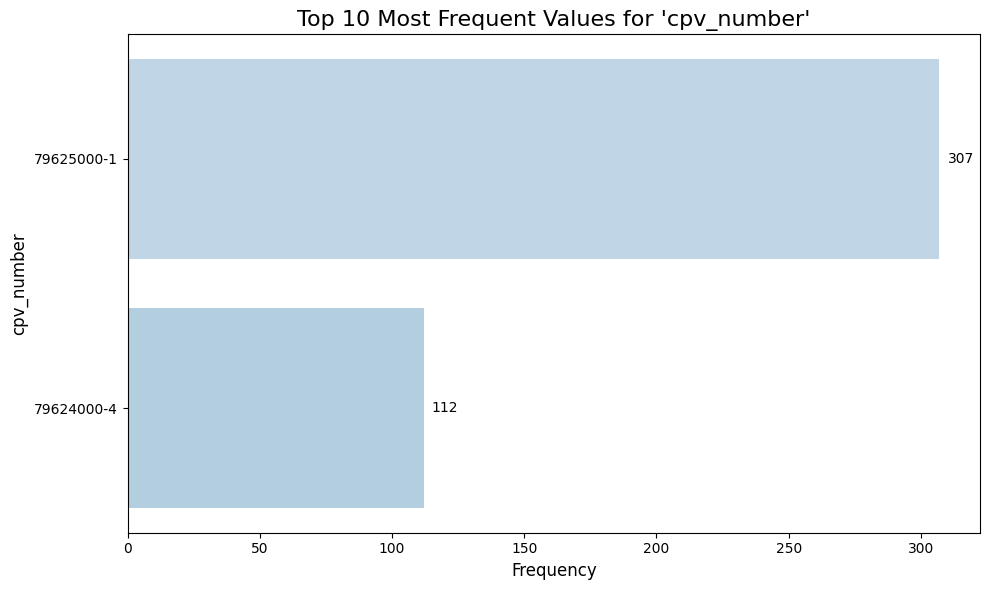

In [37]:
plot_top_n_list(df_geral_contratos_79,"cpv_number",10)

# objectoContrato

In [38]:
print_top_n(df_geral_contratos_79,"objectoContrato",10)

Top 10 most frequent values for 'objectoContrato':
objectoContrato
Aquisição serviços médicos apro - prt 14/2016/ARSN                                                                                                               6
Aquisição de Serviços Médicos APROV-PRT04/2016/ARSN                                                                                                              6
Aquisição de Serviços Médicos e Enfermagem para HFAR PL e PP                                                                                                     5
Aquisição de serviços médicos APROV-PRT 01/2016/ACES Alto e Baixo Tâmega/ARSN                                                                                    5
Aquisição de Serviços de Cuidados Médicos na Área de Otorrinolaringologia para o período de 01/07/2017 a 31/08/2018, Centro Hospitalar de Lisboa Central, EPE    4
Aquisição de Serviços Médicos e de Enfermagem para HFAR- PL e PP                                                      

In [39]:
print_bottom_n(df_geral_contratos_79,"objectoContrato",30)

Bottom 30 least frequent values for 'objectoContrato':
objectoContrato
Aquisição da Prestação de Serviços Médicos – Médico Especialista para o Serviço de Reumatologia do Hospital Divino Espírito Santo de Ponta Delgada, EPER, celebrado ao abrigo dos artigos 6. -A do Código dos Contratos Públicos    1
4SI0001/2015 Serviços Médicos de Não Especialistas para a Urgência Geral, para ano 2015                                                                                                                                             1
Contrato de Avença 03/2024 - Medica Fisiatra                                                                                                                                                                                        1
Aquisição de serviços de enfermagem Unidades do DICAD - CRI de Viana do Castelo                                                                                                                                                     1
Aquisição

In [40]:
# Show full column width (None for unlimited or use a large value like 1000)
pd.set_option('display.max_colwidth', None)
# Wrap text using HTML styling
display(HTML(df_geral_contratos_79[['objectoContrato']].head(10).to_html(escape=False).replace('\\n', '<br>')))

,objectoContrato
14340,Prestação de serviços médicos - direção clínica das Termas da Fonte Santa.
21910,"Prestação de serviços médicos na especialidade de Cirurgia Geral, ao abrigo do contrato público de aprovisionamento, no âmbito de urgência e de outras atividades do Centro Hospitalar Póvoa de Varzim / Vila do Conde, E.P.E."
25525,4S0001/2015 - Prestação de Serviços para realização de Electromiogramas e Electroencefalogramas
25656,4SI0002/2015 Serviços Médicos de Não Especialistas para a Urgência Pediátrica
25688,4SI0003/2015 Serviços Médicos de Anestesia
25704,4SI0004/2015 Serviços Médicos de Medicina
25713,4SI0005/2015 Serviços Médicos de Ginecologia/Obstetricia
25719,4SI0006/2015 Serviços Médicos de Pediatria
25724,4SI0007/2015 Serviços Médicos de Cirurgia Geral
25745,4SI0008/2015 Serviços Médicos de Psiquiatria


# tipoContrato

In [41]:
count_null_and_empty(df_geral_contratos_79, 'tipoContrato')

Null (NaN) values: 0 (0.00%)
Empty string values: 0 (0.00%)


C:\Users\susana.f.ferreira\AppData\Local\Temp\ipykernel_28084\4203078578.py:14: UserWarning: The palette list has more values (15) than needed (2), which may not be intended.
  ax = sns.barplot(


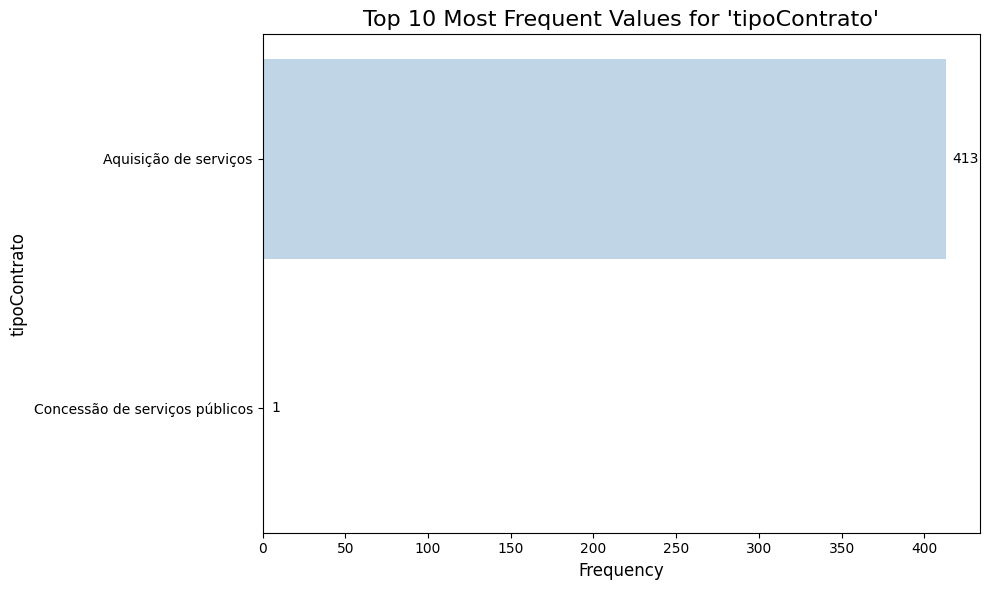

In [42]:
plot_top_n_list(df_geral_contratos_79,"tipoContrato",10)

# Listar os tipos de procedimento (contratos, anúncios, ...)

In [43]:
print_top_n_sorted(df_geral_contratos_79,"tipoContrato",10)

Top 10 most frequent values for 'tipoContrato' (sorted by value):
tipoContrato
(Aquisição de serviços,)             413
(Concessão de serviços públicos,)      1
Name: count, dtype: int64


In [44]:
df_geral_contratos_79['tipoContrato_str'] = df_geral_contratos_79['tipoContrato'].apply(
    lambda x: x[0] if isinstance(x, (list, tuple)) and len(x) > 0 else x
)
filtered_rows = df_geral_contratos_79[df_geral_contratos_79['tipoContrato_str'] == "Concessão de serviços públicos"]
print(filtered_rows)

        idcontrato nAnuncio TipoAnuncio  idINCM                       tipoContrato  idprocedimento            tipoprocedimento                                                                                                                                                     objectoContrato                                                                                                                                                        descContrato                                                                     adjudicante                                   adjudicatarios dataPublicacao dataCelebracaoContrato  precoContratual                                                         cpv  prazoExecucao                                           localExecucao                                                                   fundamentacao  ProcedimentoCentralizado  numAcordoQuadro DescrAcordoQuadro  precoBaseProcedimento dataDecisaoAdjudicacao dataFechoContrato  PrecoTotalEfetivo       

In [45]:
count_null_and_empty(df_geral_contratos_79, 'tipoprocedimento')

Null (NaN) values: 0 (0.00%)
Empty string values: 0 (0.00%)


C:\Users\susana.f.ferreira\AppData\Local\Temp\ipykernel_28084\4203078578.py:14: UserWarning: The palette list has more values (15) than needed (7), which may not be intended.
  ax = sns.barplot(


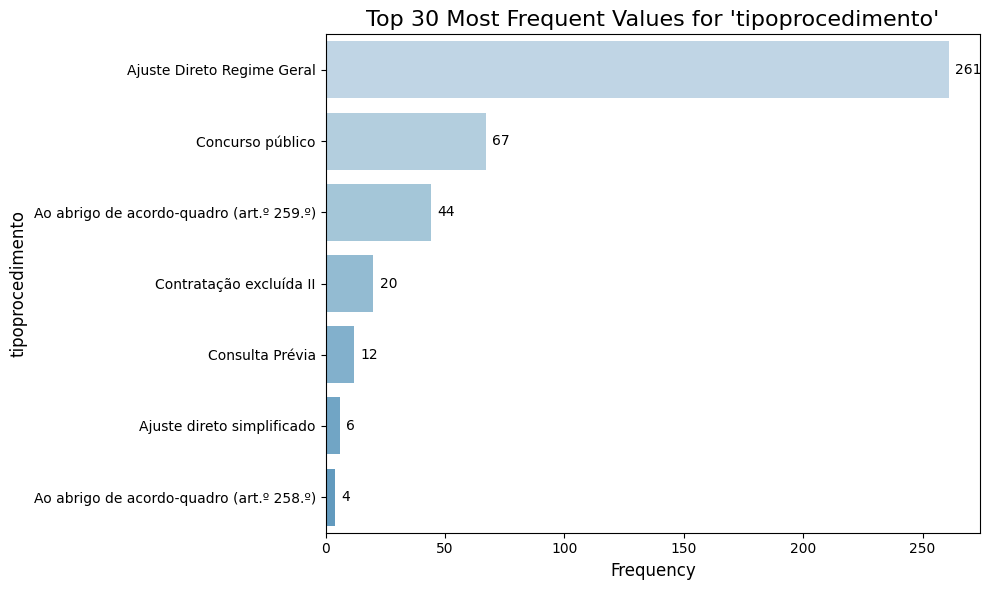

In [46]:
plot_top_n_list(df_geral_contratos_79,"tipoprocedimento",30)

# Adjudicante

In [47]:
count_null_and_empty(df_geral_contratos_79, 'adjudicante_description')

Null (NaN) values: 0 (0.00%)
Empty string values: 0 (0.00%)


C:\Users\susana.f.ferreira\AppData\Local\Temp\ipykernel_28084\4203078578.py:14: UserWarning: The palette list has more values (15) than needed (10), which may not be intended.
  ax = sns.barplot(


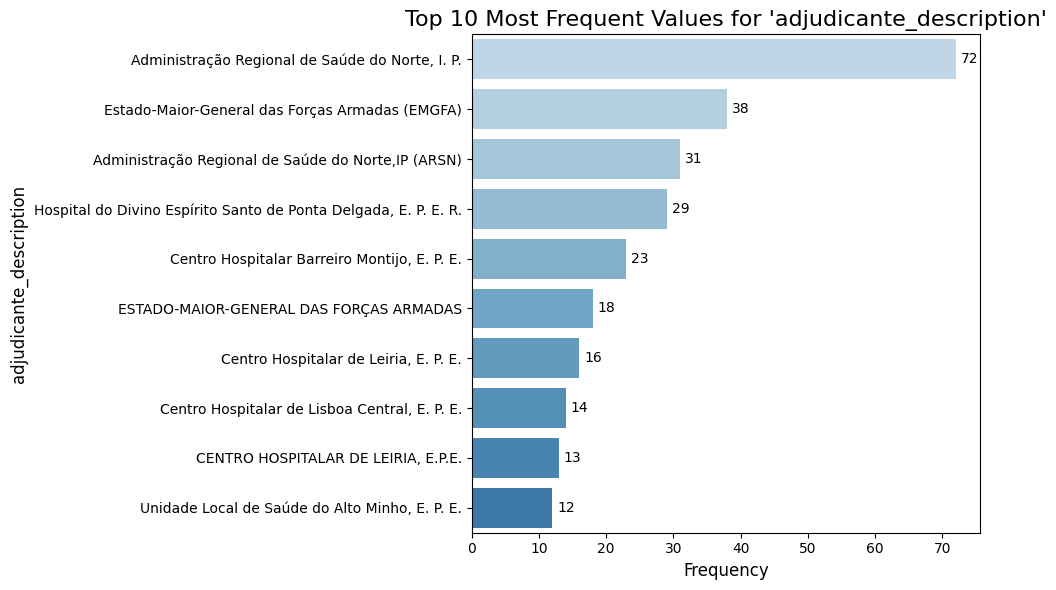

In [48]:
plot_top_n_list(df_geral_contratos_79,"adjudicante_description",10)

# Adjudicatário

In [49]:
count_null_and_empty(df_geral_contratos_79, 'adjudicatarios_description')

Null (NaN) values: 1 (0.24%)
Empty string values: 0 (0.00%)


C:\Users\susana.f.ferreira\AppData\Local\Temp\ipykernel_28084\4203078578.py:14: UserWarning: The palette list has more values (15) than needed (10), which may not be intended.
  ax = sns.barplot(


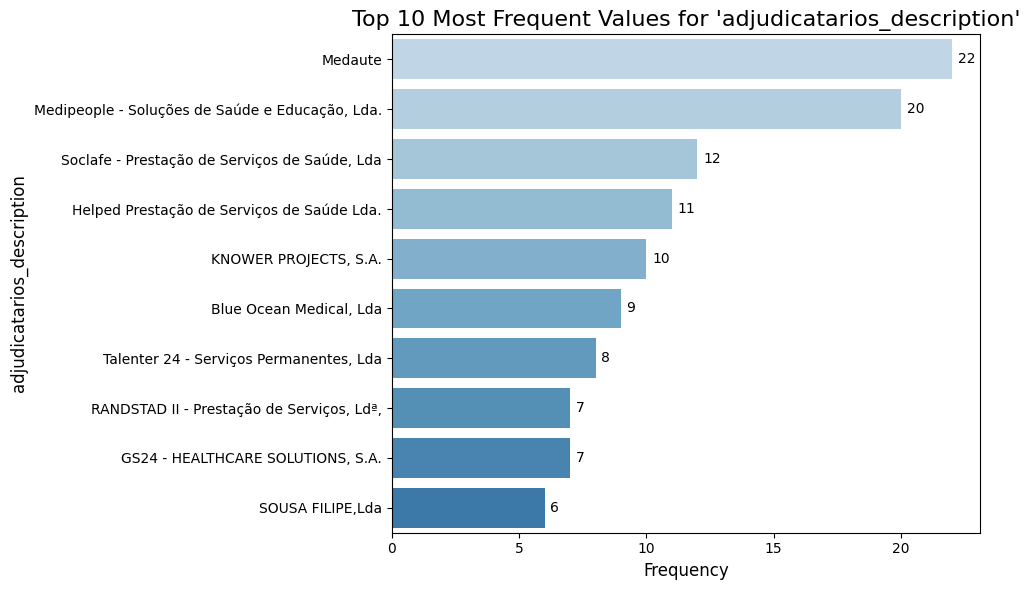

In [50]:
plot_top_n_list(df_geral_contratos_79,"adjudicatarios_description",10)

# Ano Data de Celebração do Contrato

In [51]:
count_null_and_empty(df_geral_contratos_79, 'anoDataCelebracaoContrato')

Null (NaN) values: 6 (1.45%)
Empty string values: 0 (0.00%)


In [52]:
celebrations_per_year = df_geral_contratos_79['anoDataCelebracaoContrato'].value_counts(dropna=False).sort_index()
print(celebrations_per_year)

anoDataCelebracaoContrato
2015.0    53
2016.0    76
2017.0    37
2018.0    25
2019.0    33
2020.0    13
2021.0    40
2022.0    33
2023.0    41
2024.0    57
NaN        6
Name: count, dtype: int64


In [53]:
def plot_per_year(column_values,column_name):
    # Create DataFrame from the series
    df_year_counts = pd.DataFrame({
        'Year': column_values.index.astype(str),
        'Count': column_values.values
    })

    # Create the plot
    plt.figure(figsize=(12, 6))
    barplot = sns.barplot(data=df_year_counts, x='Year', y='Count', hue='Year', palette=colors, legend=False)

    # Annotate each bar with its height (publication count)
    for p in barplot.patches:
        height = int(p.get_height())
        barplot.annotate(f'{height}', 
                         (p.get_x() + p.get_width() / 2., height), 
                         ha='center', va='bottom', 
                         fontsize=9, color='black')

    # Add labels and title
    plt.xlabel(f"Year of '{column_name}' ", fontsize=12)
    plt.ylabel(f"Number of '{column_name}' ", fontsize=12)
    plt.title(f"Number of '{column_name}' per Year", fontsize=14)
    
    # Rotate x-axis labels for better readability
    plt.xticks(rotation=45)
    
    # Adjust layout
    plt.tight_layout()
    
    # Show the plot
    plt.show()

C:\Users\susana.f.ferreira\AppData\Local\Temp\ipykernel_28084\1893969387.py:10: UserWarning: The palette list has more values (15) than needed (11), which may not be intended.
  barplot = sns.barplot(data=df_year_counts, x='Year', y='Count', hue='Year', palette=colors, legend=False)


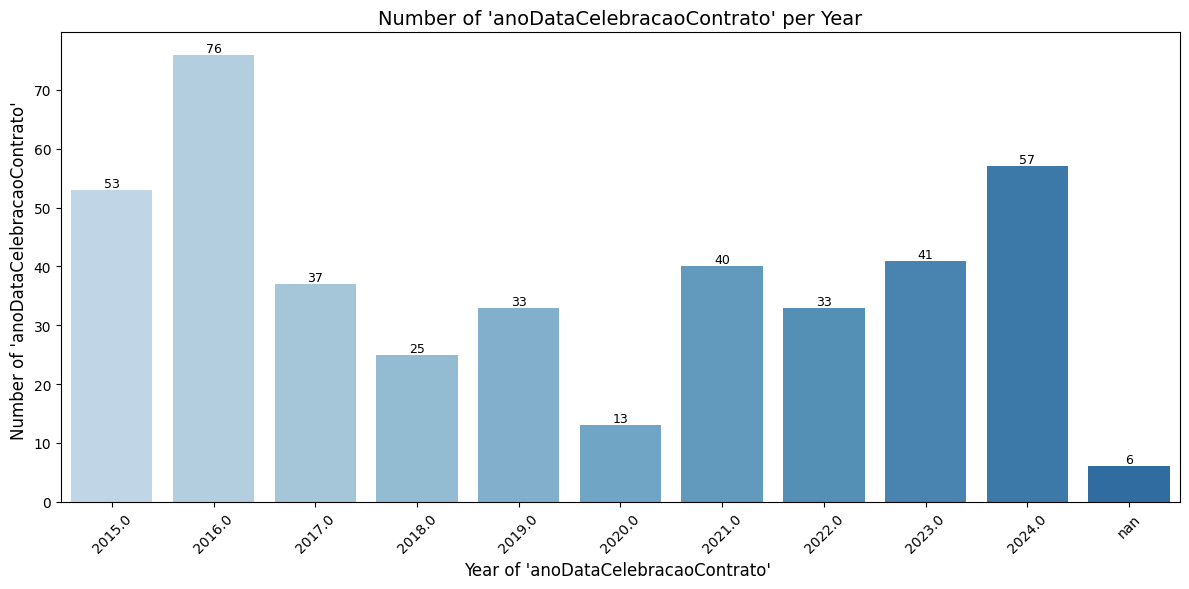

In [54]:
plot_per_year(celebrations_per_year,'anoDataCelebracaoContrato')

In [55]:
# Filter and display rows with NaN in 'anoDataCelebracaoContrato'
df_nan_years = df_geral_contratos_79[df_geral_contratos_79['anoDataCelebracaoContrato'].isna()]
# Show how many and display first few
print(f"Number of rows with NaN in 'anoDataCelebracaoContrato': {len(df_nan_years)}")
display(df_nan_years.head(5))

Number of rows with NaN in 'anoDataCelebracaoContrato': 6


,idcontrato,nAnuncio,TipoAnuncio,idINCM,tipoContrato,idprocedimento,tipoprocedimento,objectoContrato,descContrato,adjudicante,adjudicatarios,dataPublicacao,dataCelebracaoContrato,precoContratual,cpv,prazoExecucao,localExecucao,fundamentacao,ProcedimentoCentralizado,numAcordoQuadro,DescrAcordoQuadro,precoBaseProcedimento,dataDecisaoAdjudicacao,dataFechoContrato,PrecoTotalEfetivo,regime,justifNReducEscrContrato,tipoFimContrato,CritMateriais,concorrentes,linkPecasProc,Observacoes,ContratEcologico,Ano,fundamentAjusteDireto,adjudicante_string,adjudicante_nipc,adjudicante_description,adjudicatarios_string,adjudicatarios_nipc,adjudicatarios_description,dataPublicacaoParsed,anoPublicação,dataCelebracaoContratoParsed,anoDataCelebracaoContrato,precoContratualInterval,cpv_string,cpv_number,cpv_description,prazoExecucaoIntervalo,precoBaseProcedimentoInterval,dataDecisaoAdjudicacaoParsed,anoDataDecisaoAdjudicacao,dataFechoContratoParsed,anoDataFechoContrato,PrecoTotalEfetivoInterval,concorrentes_string,concorrentes_nipc,concorrentes_description,Fonte_Arquivo,tipoContrato_str
723513,7101971,,,<NA>,"(Aquisição de serviços,)",4838433,Ajuste direto simplificado,NRO 2020/00341 - serviços de enfermagem no âmbito da COVID 19,NRO 2020/00341 - serviços de enfermagem no âmbito da COVID 19,"(501328599 - Autoridade de Supervisão de Seguros e Fundos de Pensões (ASF),)","(509133398 - Medialcare-Saúde, Prevenção e Bem Estar,S.A,)",01/10/2020,,12150.00,"(79624000-4 - Serviços de fornecimento de pessoal de enfermagem,)",0,None,,False,<NA>,,0.0,,09/06/2020,12150.00,"Decreto-Lei n.º 10-A/2020, de 13.03",<NA>,,False,None,,,False,2020,,['501328599 - Autoridade de Supervisão de Seguros e Fundos de Pensões (ASF)'],"(501328599,)","(Autoridade de Supervisão de Seguros e Fundos de Pensões (ASF),)","['509133398 - Medialcare-Saúde, Prevenção e Bem Estar,S.A']","(509133398,)","(Medialcare-Saúde, Prevenção e Bem Estar,S.A,)",2020-10-01,2020,NaT,NaN,"5,001 € to 50,000 €",['79624000-4 - Serviços de fornecimento de pessoal de enfermagem'],"(79624000-4,)","(Serviços de fornecimento de pessoal de enfermagem,)",NaN,zero,NaT,NaN,2020-06-09,2020.0,"5,001 € to 50,000 €",<NA>,None,None,csv_resultados_2020.parquet,Aquisição de serviços
828003,7576044,,,<NA>,"(Aquisição de serviços,)",5228396,Ajuste direto simplificado,AQUISIÇÃO DE SERVIÇOS D ENFERMAGEM PARA REALIZAÇÃO DE TESTES COVID (50 H),AQUISIÇÃO DE SERVIÇOS D ENFERMAGEM PARA REALIZAÇÃO DE TESTES COVID (50 H),"(506510476 - Município de Gouveia,)","(- - SERGIO FILIPE FERREIRA LOPES,)",19/03/2021,,500.00,"(79624000-4 - Serviços de fornecimento de pessoal de enfermagem,)",0,None,,False,<NA>,,0.0,,17/02/2021,500.00,"Decreto-Lei n.º 10-A/2020, de 13.03",<NA>,,False,None,,,False,2021,,['506510476 - Município de Gouveia'],"(506510476,)","(Município de Gouveia,)",['- - SERGIO FILIPE FERREIRA LOPES'],"(None,)","(None,)",2021-03-19,2021,NaT,NaN,"Up to 5,000 €",['79624000-4 - Serviços de fornecimento de pessoal de enfermagem'],"(79624000-4,)","(Serviços de fornecimento de pessoal de enfermagem,)",NaN,zero,NaT,NaN,2021-02-17,2021.0,"Up to 5,000 €",<NA>,None,None,csv_resultados_2021.parquet,Aquisição de serviços
828005,7576056,,,<NA>,"(Aquisição de serviços,)",5228419,Ajuste direto simplificado,AQUISIÇÃO DE SERVIÇOS DE ENFERMAGEM PARA REALIZAÇÃO DE TESTE COVID (50 H),AQUISIÇÃO DE SERVIÇOS DE ENFERMAGEM PARA REALIZAÇÃO DE TESTE COVID (50 H),"(506510476 - Município de Gouveia,)","(- - ANA MARISA SOUSA SEQUEIRA,)",19/03/2021,,500.00,"(79624000-4 - Serviços de fornecimento de pessoal de enfermagem,)",0,None,,False,<NA>,,0.0,,17/02/2021,500.00,"Decreto-Lei n.º 10-A/2020, de 13.03",<NA>,,False,None,,,False,2021,,['506510476 - Município de Gouveia'],"(506510476,)","(Município de Gouveia,)",['- - ANA MARISA SOUSA SEQUEIRA'],"(None,)","(None,)",2021-03-19,2021,NaT,NaN,"Up to 5,000 €",['79624000-4 - Serviços de fornecimento de pessoal de enfermagem'],"(79624000-4,)","(Serviços de fornecimento de pessoal de enfermagem,)",NaN,zero,NaT,NaN,2021-02-17,

# Ano

In [56]:
count_null_and_empty(df_geral_contratos_79, 'Ano')

Null (NaN) values: 0 (0.00%)
Empty string values: 0 (0.00%)


In [57]:
print_top_n_sorted(df_geral_contratos_79,"Ano",10)

Top 10 most frequent values for 'Ano' (sorted by value):
Ano
2015    53
2016    76
2017    37
2018    25
2019    33
2020    14
2021    45
2022    33
2023    41
2024    57
Name: count, dtype: int64


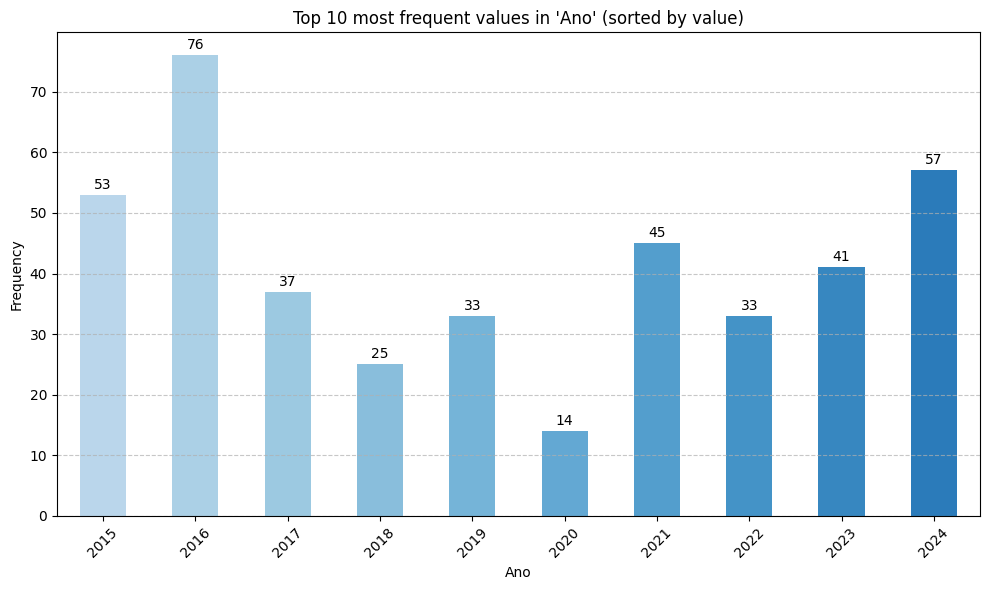

In [58]:
plot_top_n_sorted_with_counts(df_geral_contratos_79, "Ano", 10)

# Preço Contratual by Procurement Interval

In [59]:
count_null_and_empty(df_geral_contratos_79, 'precoContratual')

Null (NaN) values: 0 (0.00%)
Empty string values: 0 (0.00%)


In [60]:
# Apply binning safely
df_geral_contratos_79.loc[:, 'precoContratualInterval'] = pd.cut(
    df_geral_contratos_79['precoContratual'],
    bins=bins,
    labels=labels
)
# Count the occurrences in each interval
count_by_interval = df_geral_contratos_79['precoContratualInterval'].value_counts().sort_index()
print(count_by_interval)

precoContratualInterval
zero                          1
Up to 5,000 €                47
5,001 € to 50,000 €         239
50,001 € to 139,000 €        61
139,001 € to 5,350,000 €     66
Above 5,350,000 €             0
Name: count, dtype: int64


C:\Users\susana.f.ferreira\AppData\Local\Temp\ipykernel_28084\2040405077.py:2: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise in a future error of pandas. Value '['5,001 € to 50,000 €', '50,001 € to 139,000 €', '5,001 € to 50,000 €', '139,001 € to 5,350,000 €', '139,001 € to 5,350,000 €', ..., '50,001 € to 139,000 €', '5,001 € to 50,000 €', '5,001 € to 50,000 €', '5,001 € to 50,000 €', '5,001 € to 50,000 €']
Length: 414
Categories (6, object): ['zero' < 'Up to 5,000 €' < '5,001 € to 50,000 €' < '50,001 € to 139,000 €' < '139,001 € to 5,350,000 €' < 'Above 5,350,000 €']' has dtype incompatible with category, please explicitly cast to a compatible dtype first.
  df_geral_contratos_79.loc[:, 'precoContratualInterval'] = pd.cut(


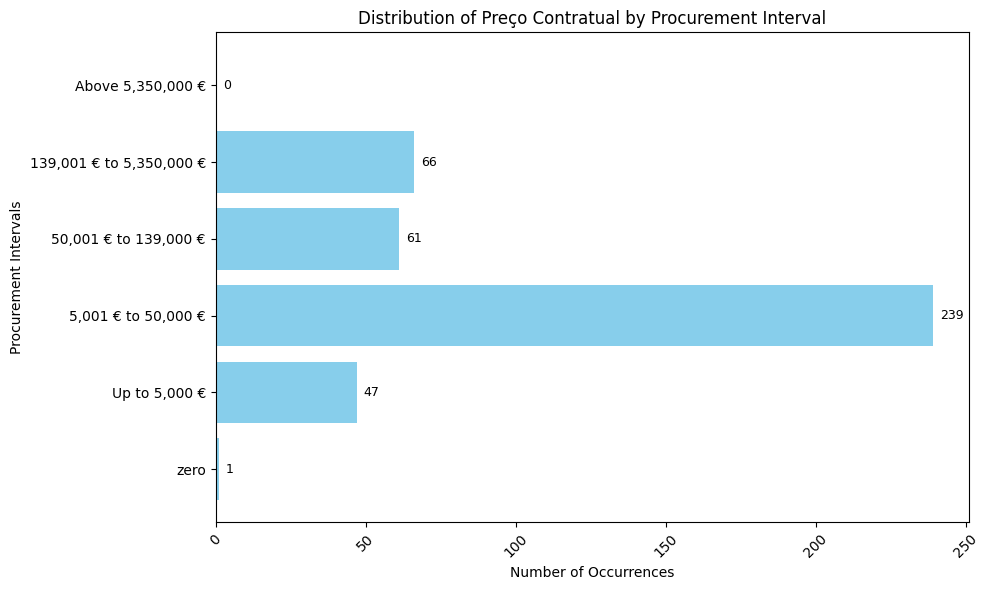

In [61]:
plot_horizontal_bar(
    count_by_interval,
    title="Distribution of Preço Contratual by Procurement Interval",
    xlabel="Number of Occurrences",
    ylabel="Procurement Intervals"
)

# precoBaseProcedimento

In [62]:
count_null_and_empty(df_geral_contratos_79, 'precoBaseProcedimento')

Null (NaN) values: 0 (0.00%)
Empty string values: 0 (0.00%)


In [63]:
# Apply binning safely
df_geral_contratos_79.loc[:, 'precoBaseProcedimentoInterval'] = pd.cut(
    df_geral_contratos_79['precoBaseProcedimento'],
    bins=bins,
    labels=labels
)
# Count the occurrences in each interval
count_by_interval = df_geral_contratos_79['precoBaseProcedimentoInterval'].value_counts().sort_index()
print(count_by_interval)

precoBaseProcedimentoInterval
zero                         50
Up to 5,000 €                39
5,001 € to 50,000 €         183
50,001 € to 139,000 €        74
139,001 € to 5,350,000 €     67
Above 5,350,000 €             1
Name: count, dtype: int64


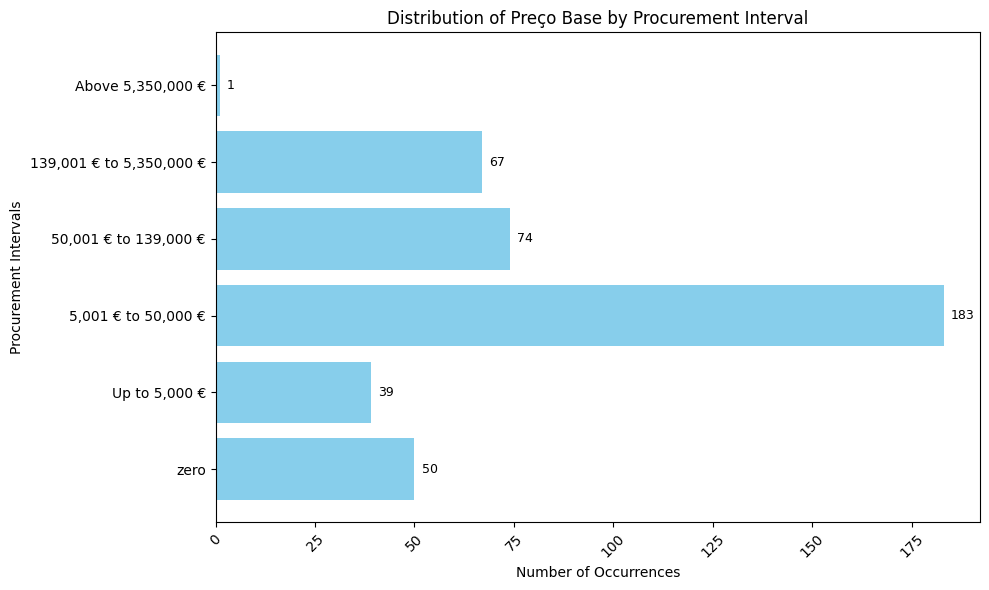

In [64]:
plot_horizontal_bar(
    count_by_interval,
    title="Distribution of Preço Base by Procurement Interval",
    xlabel="Number of Occurrences",
    ylabel="Procurement Intervals"
)

# Preço Total Efetivo by Procurement Interval

In [65]:
count_null_and_empty(df_geral_contratos_79, 'PrecoTotalEfetivo')

Null (NaN) values: 0 (0.00%)
Empty string values: 0 (0.00%)


In [66]:
# Apply binning safely
df_geral_contratos_79.loc[:, 'PrecoTotalEfetivoInterval'] = pd.cut(
    df_geral_contratos_79['PrecoTotalEfetivo'],
    bins=bins,
    labels=labels
)
# Count the occurrences in each interval
count_by_interval = df_geral_contratos_79['PrecoTotalEfetivoInterval'].value_counts().sort_index()
print(count_by_interval)

PrecoTotalEfetivoInterval
zero                        233
Up to 5,000 €                26
5,001 € to 50,000 €         117
50,001 € to 139,000 €        21
139,001 € to 5,350,000 €     17
Above 5,350,000 €             0
Name: count, dtype: int64


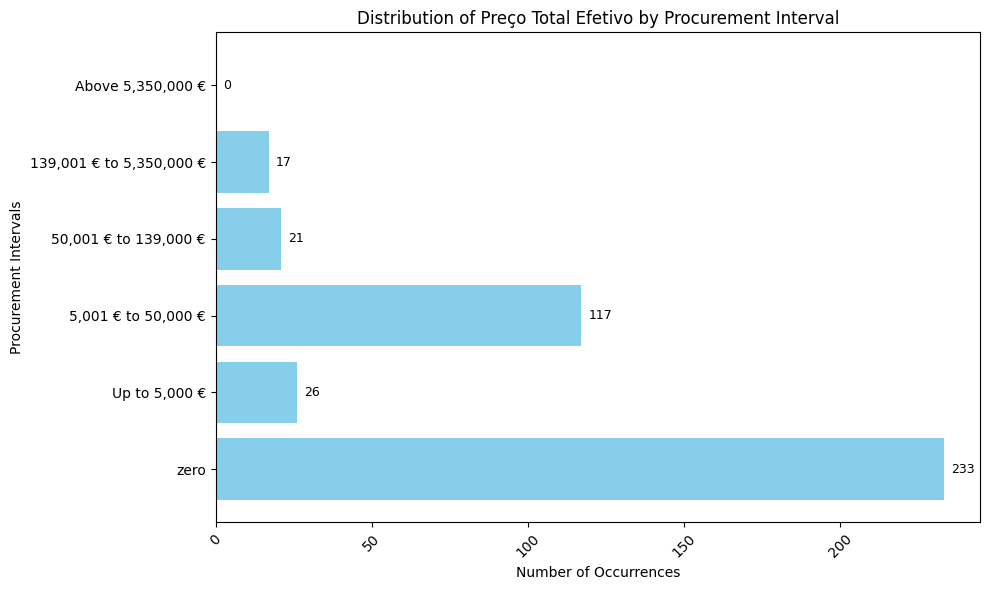

In [67]:
plot_horizontal_bar(
    count_by_interval,
    title="Distribution of Preço Total Efetivo by Procurement Interval",
    xlabel="Number of Occurrences",
    ylabel="Procurement Intervals"
)

# precoContratual, precoBaseProcedimento e PrecoTotalEfetivo by interval

In [68]:
# Create categorical interval columns for each price feature using the same bins and labels
for col in ['precoContratual', 'precoBaseProcedimento', 'PrecoTotalEfetivo']:
    df_geral_contratos_79[f'{col}Interval'] = pd.cut(df_geral_contratos_79[col], bins=bins, labels=labels)

In [69]:
# Calculate the count of occurrences in each interval for each feature
# Use reindex to ensure all labels are present and aligned, filling missing with 0
counts_pc = df_geral_contratos_79['precoContratualInterval'].value_counts().reindex(labels, fill_value=0)
counts_pb = df_geral_contratos_79['precoBaseProcedimentoInterval'].value_counts().reindex(labels, fill_value=0)
counts_pt = df_geral_contratos_79['PrecoTotalEfetivoInterval'].value_counts().reindex(labels, fill_value=0)

In [70]:
# Combine the counts into a single DataFrame for easier plotting
df_counts = pd.DataFrame({
    'Preço Contratual': counts_pc,
    'Preço Base Procedimento': counts_pb,
    'Preço Total Efetivo': counts_pt
})

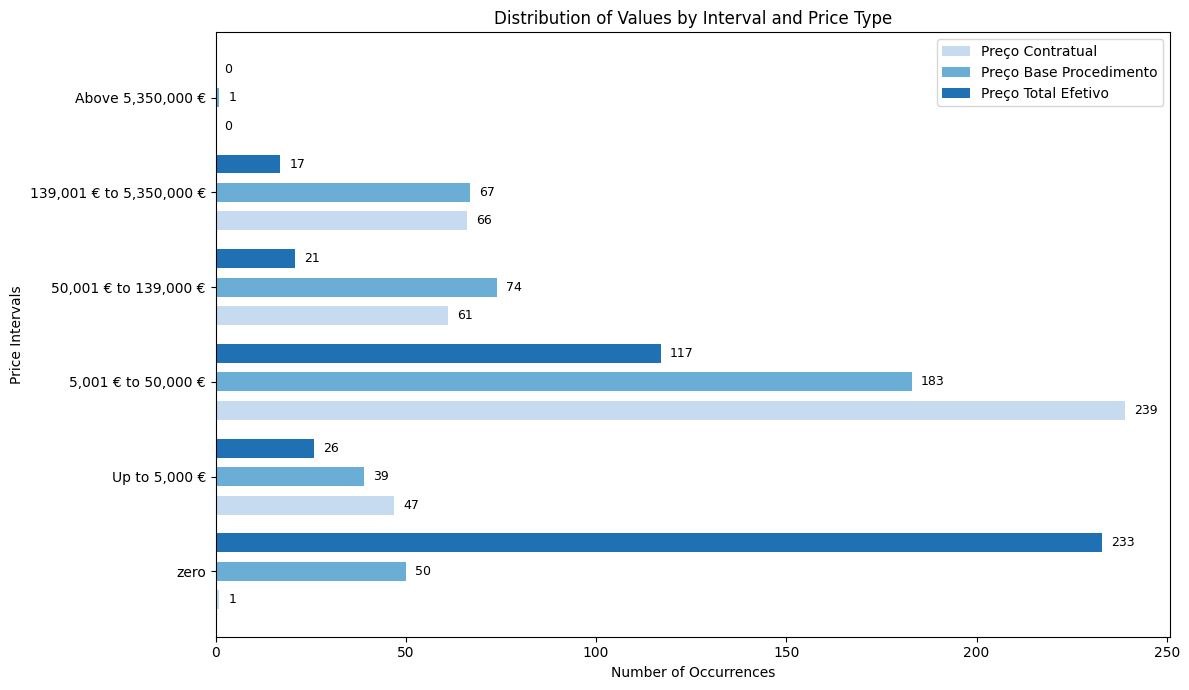

In [71]:
# Call the plotting function with the prepared data and labels
plot_grouped_horizontal_bar(
    df_counts,
    title="Distribution of Values by Interval and Price Type",
    xlabel="Number of Occurrences",
    ylabel="Price Intervals"
)

# Preço Contratual by Year

In [72]:
# Create a copy to avoid SettingWithCopyWarning
df_valid = df_geral_contratos_79[['Ano', 'precoContratual']].copy()
# Convert types safely
df_valid['Ano'] = pd.to_numeric(df_valid['Ano'], errors='coerce')
df_valid['precoContratual'] = pd.to_numeric(df_valid['precoContratual'], errors='coerce')
# Drop rows with missing values
df_valid = df_valid.dropna()
# Group and sum
sum_by_year = df_valid.groupby('Ano')['precoContratual'].sum().sort_index()

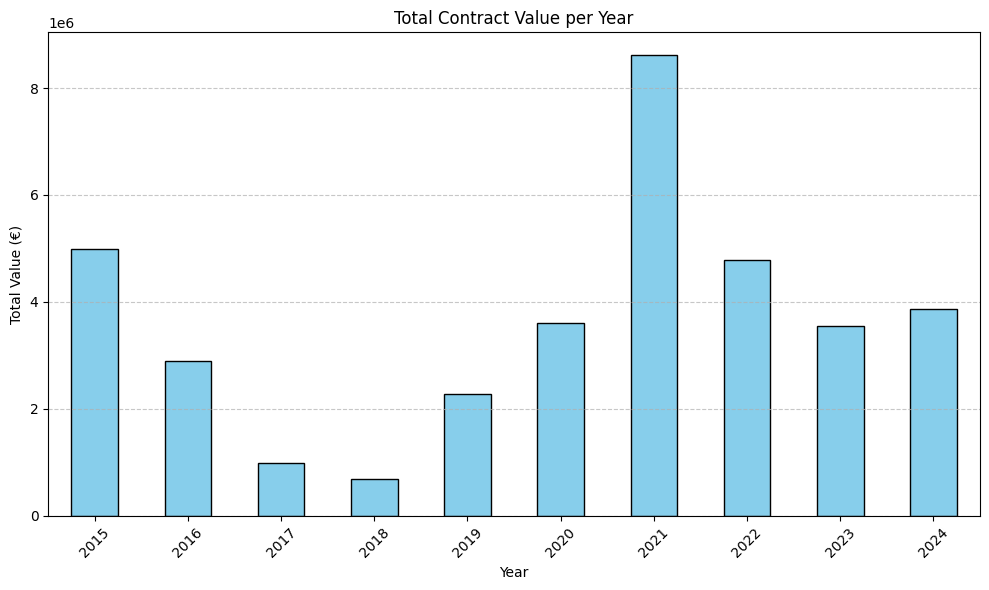

In [73]:
plt.figure(figsize=(10, 6))
sum_by_year.plot(kind='bar', color='skyblue', edgecolor='black')
plt.title('Total Contract Value per Year')
plt.xlabel('Year')
plt.ylabel('Total Value (€)')
plt.xticks(rotation=45)
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.tight_layout()
plt.show()

# Preço Base do Procedimento by Year

In [74]:
# Create a copy to avoid SettingWithCopyWarning
df_valid = df_geral_contratos_79[['Ano', 'precoBaseProcedimento']].copy()
# Convert types safely
df_valid['Ano'] = pd.to_numeric(df_valid['Ano'], errors='coerce')
df_valid['precoBaseProcedimento'] = pd.to_numeric(df_valid['precoBaseProcedimento'], errors='coerce')
# Drop rows with missing values
df_valid = df_valid.dropna()
# Group and sum
sum_by_year = df_valid.groupby('Ano')['precoBaseProcedimento'].sum().sort_index()

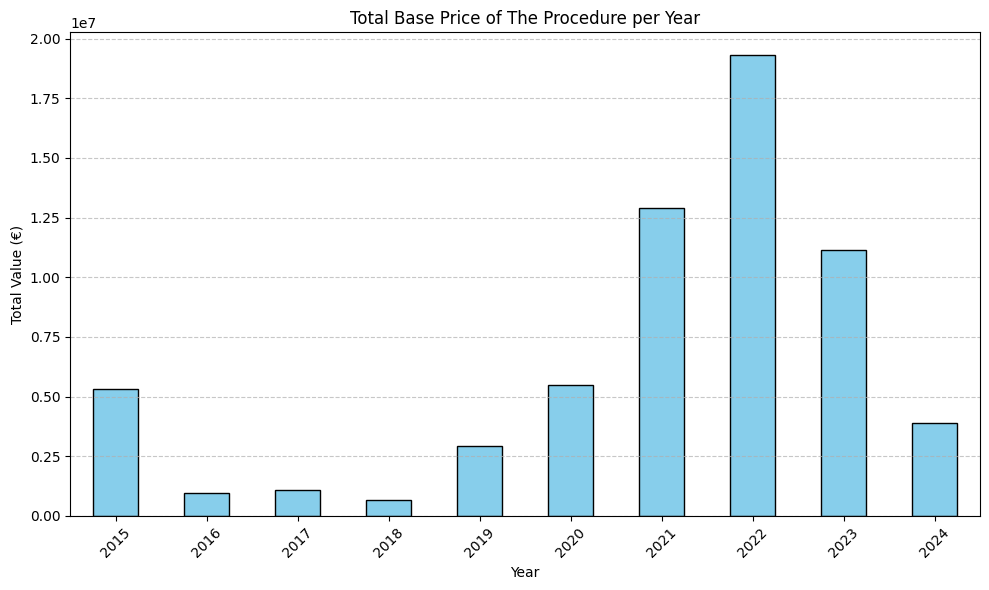

In [75]:
plt.figure(figsize=(10, 6))
sum_by_year.plot(kind='bar', color='skyblue', edgecolor='black')
plt.title('Total Base Price of The Procedure per Year')
plt.xlabel('Year')
plt.ylabel('Total Value (€)')
plt.xticks(rotation=45)
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.tight_layout()
plt.show()

# Preço Total Efetivo by Year

In [76]:
# Create a copy to avoid SettingWithCopyWarning
df_valid = df_geral_contratos_79[['Ano', 'PrecoTotalEfetivo']].copy()
# Convert types safely
df_valid['Ano'] = pd.to_numeric(df_valid['Ano'], errors='coerce')
df_valid['PrecoTotalEfetivo'] = pd.to_numeric(df_valid['PrecoTotalEfetivo'], errors='coerce')
# Drop rows with missing values
df_valid = df_valid.dropna()
# Group and sum
sum_by_year = df_valid.groupby('Ano')['PrecoTotalEfetivo'].sum().sort_index()

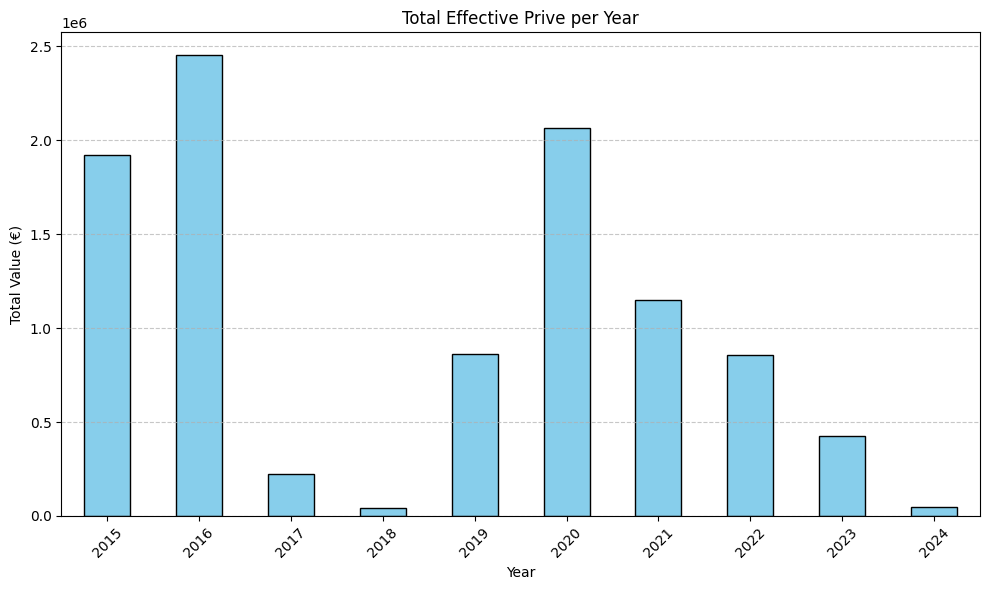

In [77]:
plt.figure(figsize=(10, 6))
sum_by_year.plot(kind='bar', color='skyblue', edgecolor='black')
plt.title('Total Effective Prive per Year')
plt.xlabel('Year')
plt.ylabel('Total Value (€)')
plt.xticks(rotation=45)
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.tight_layout()
plt.show()

# precoContratual, precoBaseProcedimento, PrecoTotalEfetivo by year

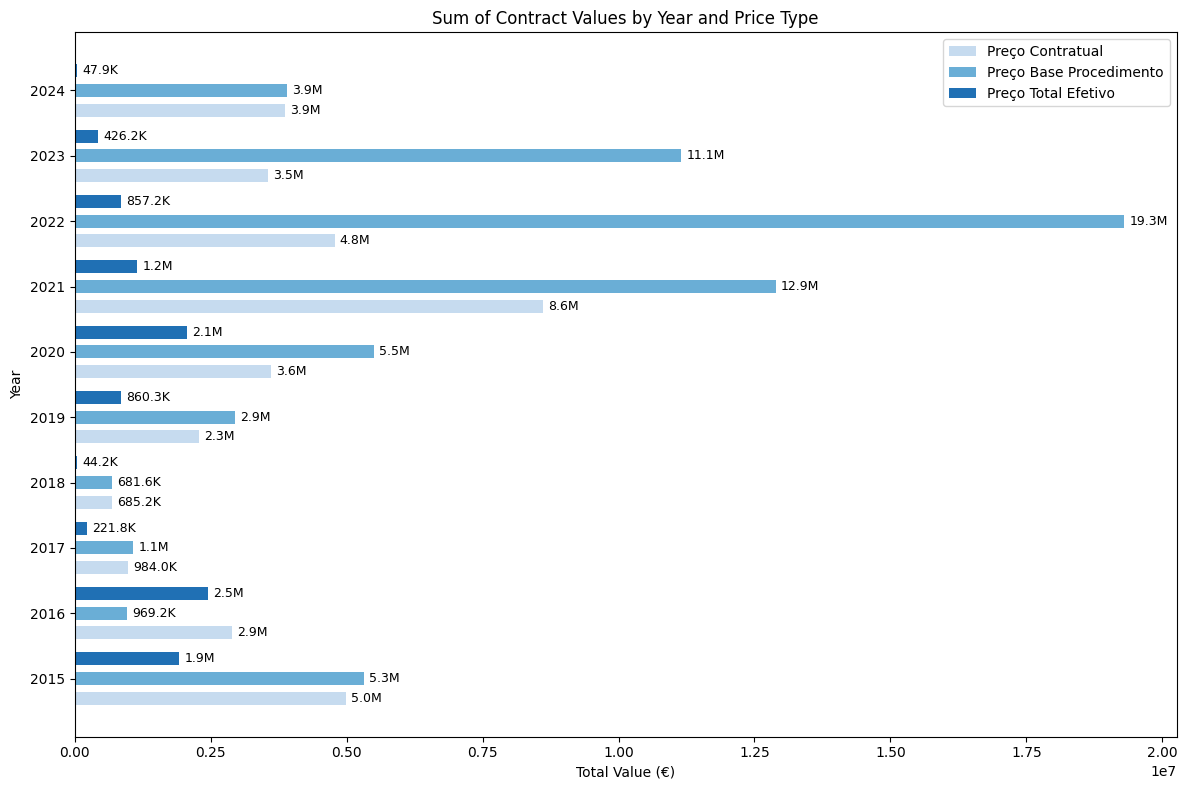

In [78]:
# Group by 'Ano' and sum the three price features
df_sums_by_year = df_geral_contratos_79.groupby('Ano')[
    ['precoContratual', 'precoBaseProcedimento', 'PrecoTotalEfetivo']
].sum()

# Rename columns for better labels
df_sums_by_year.columns = ['Preço Contratual', 'Preço Base Procedimento', 'Preço Total Efetivo']

# Optional: sort by year
df_sums_by_year = df_sums_by_year.sort_index()

# Plot
plot_grouped_sum_horizontal_bar(
    df_sums_by_year,
    title="Sum of Contract Values by Year and Price Type",
    xlabel="Total Value (€)",
    ylabel="Year"
)


# Number of zero values of precoContratual, precoBaseProcedimento, PrecoTotalEfetivo by year

In [79]:
# Count number of zero values by year for each feature
df_zeros_by_year = df_geral_contratos_79.groupby('Ano')[
    ['precoContratual', 'precoBaseProcedimento', 'PrecoTotalEfetivo']
].apply(lambda x: (x == 0).sum())
# Rename columns for clarity
df_zeros_by_year.columns = ['Preço Contratual = 0', 'Preço Base Procedimento = 0', 'Preço Total Efetivo = 0']
# Optional: sort by year
df_zeros_by_year = df_zeros_by_year.sort_index()
print(df_zeros_by_year)

      Preço Contratual = 0  Preço Base Procedimento = 0  Preço Total Efetivo = 0
Ano                                                                             
2015                     0                            1                        9
2016                     0                           30                        4
2017                     0                            2                       22
2018                     0                            7                       22
2019                     0                            2                       12
2020                     0                            1                        7
2021                     0                            5                       35
2022                     1                            1                       28
2023                     0                            0                       39
2024                     0                            1                       55


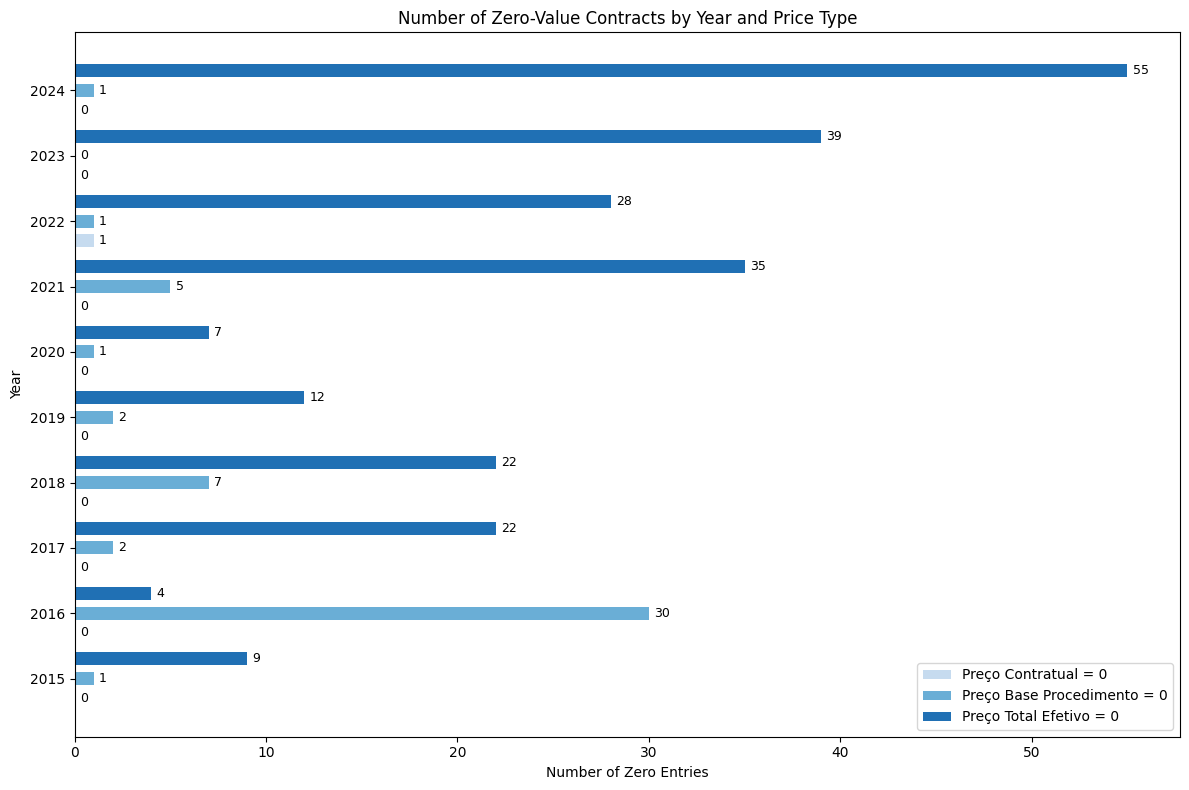

In [80]:
plot_grouped_sum_horizontal_bar(
    df_zeros_by_year,
    title="Number of Zero-Value Contracts by Year and Price Type",
    xlabel="Number of Zero Entries",
    ylabel="Year"
)


# Comparing 'precoContratual', 'precoBaseProcedimento', 'PrecoTotalEfetivo' with other features

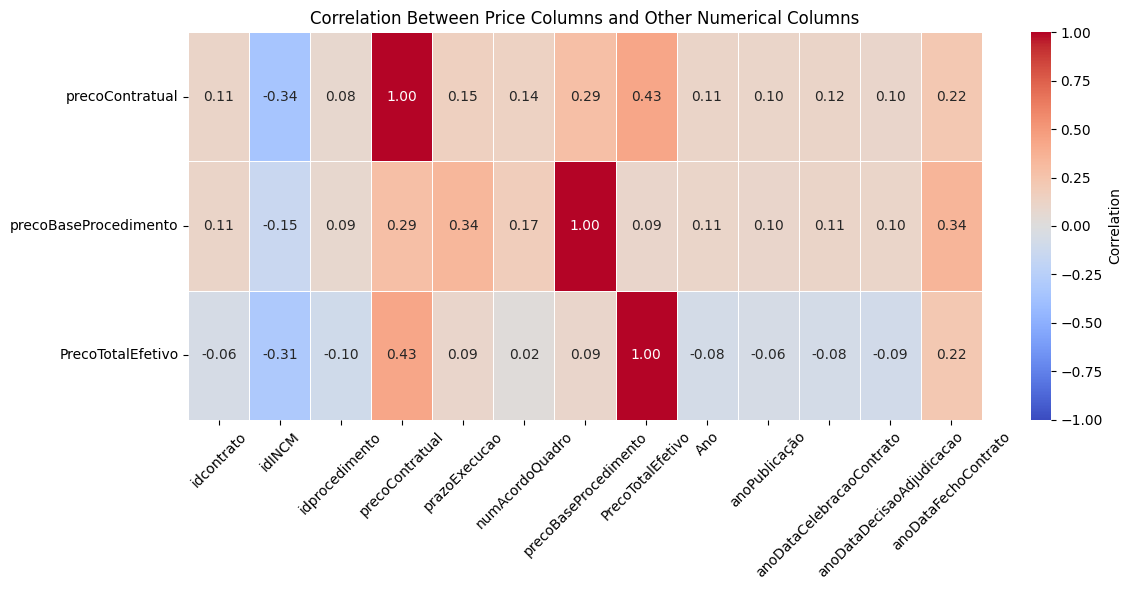

In [81]:
# Convert price columns to numeric type, if they haven't been converted yet
for col in ['precoContratual', 'precoBaseProcedimento', 'PrecoTotalEfetivo']:
    df_geral_contratos_79[col] = pd.to_numeric(df_geral_contratos_79[col], errors='coerce')
# Select numeric columns only
numeric_df = df_geral_contratos_79.select_dtypes(include='number')
# Calculate the correlation matrix
correlation_matrix = numeric_df.corr()
# Focus only on the correlations with the 3 columns of interest
target_corr = correlation_matrix.loc[
    ['precoContratual', 'precoBaseProcedimento', 'PrecoTotalEfetivo']
]
# Ploting heatmap
plt.figure(figsize=(12, 6))
sns.heatmap(
    target_corr,
    annot=True,
    fmt=".2f",
    cmap='coolwarm',
    vmin=-1, vmax=1,
    linewidths=0.5,
    cbar_kws={'label': 'Correlation'}
)
plt.title("Correlation Between Price Columns and Other Numerical Columns")
plt.yticks(rotation=0, fontsize=10)
plt.xticks(rotation=45, fontsize=10)
plt.tight_layout()
plt.show()

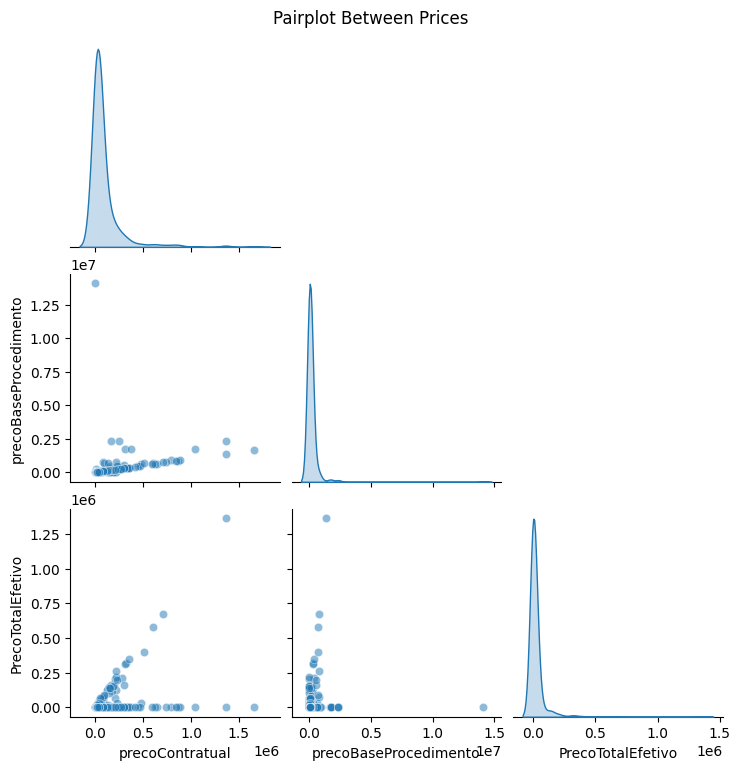

In [82]:
cols = ['precoContratual', 'precoBaseProcedimento', 'PrecoTotalEfetivo']
sns.pairplot(df_geral_contratos_79[cols], diag_kind='kde', corner=True, plot_kws={'alpha':0.5})
plt.suptitle("Pairplot Between Prices", y=1.02)
plt.show()

C:\Users\susana.f.ferreira\AppData\Local\Temp\ipykernel_28084\1727275477.py:4: UserWarning: The palette list has more values (15) than needed (10), which may not be intended.
  sns.barplot(
C:\Users\susana.f.ferreira\AppData\Local\Temp\ipykernel_28084\1727275477.py:4: UserWarning: The palette list has more values (15) than needed (10), which may not be intended.
  sns.barplot(
C:\Users\susana.f.ferreira\AppData\Local\Temp\ipykernel_28084\1727275477.py:4: UserWarning: The palette list has more values (15) than needed (10), which may not be intended.
  sns.barplot(


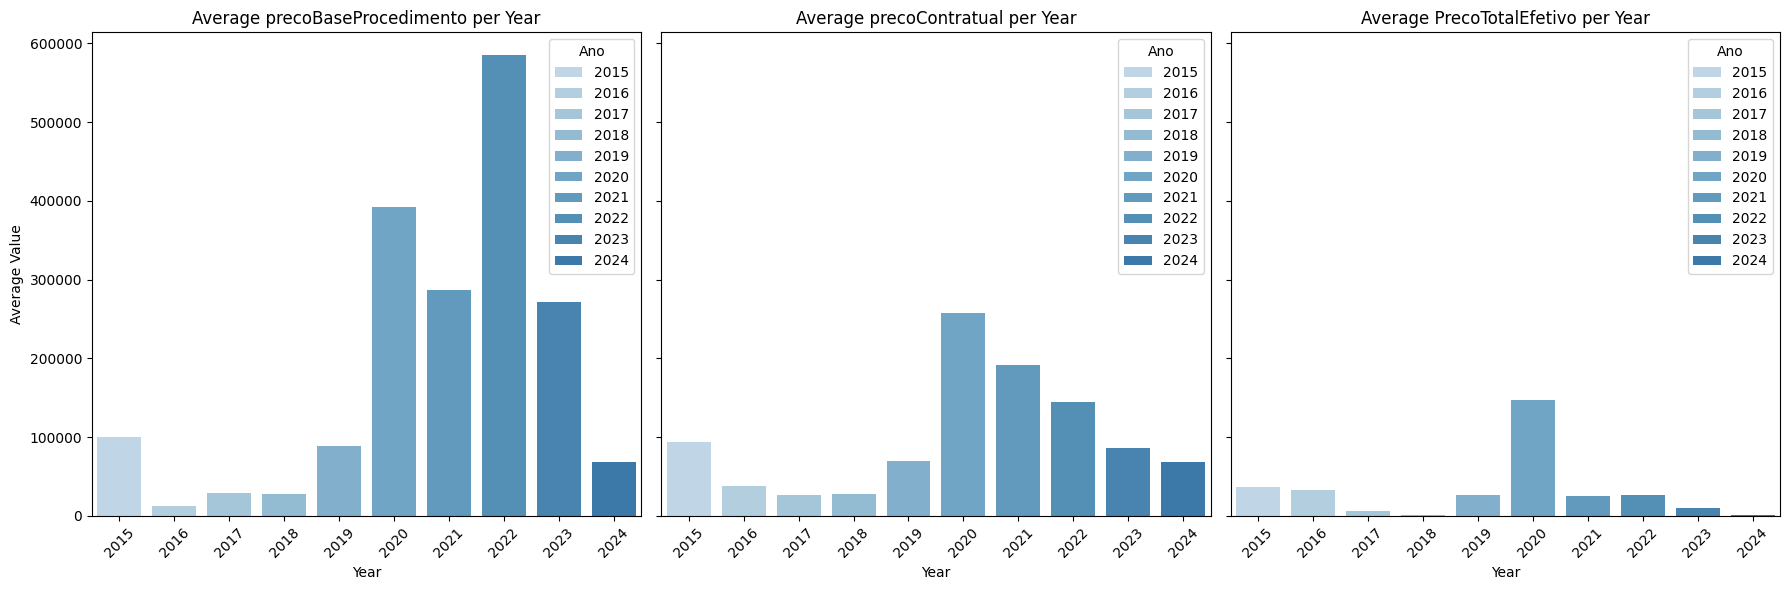

In [83]:
features = ['precoBaseProcedimento', 'precoContratual', 'PrecoTotalEfetivo']
fig, axs = plt.subplots(1, 3, figsize=(18, 6), sharex=True, sharey=True)
for ax, col in zip(axs, features):
    sns.barplot(
        data=df_geral_contratos_79,
        x='Ano',
        y=col,
        estimator='mean',
        errorbar=None,
        ax=ax,
        hue='Ano',
        palette=colors
    )
    ax.set_title(f'Average {col} per Year')
    ax.set_xlabel('Year')
    ax.set_ylabel('Average Value')
    ax.tick_params(axis='x', rotation=45)

plt.tight_layout()
plt.show()

C:\Users\susana.f.ferreira\AppData\Local\Temp\ipykernel_28084\1710425705.py:5: UserWarning: The palette list has more values (15) than needed (10), which may not be intended.
  sns.boxplot(
C:\Users\susana.f.ferreira\AppData\Local\Temp\ipykernel_28084\1710425705.py:5: UserWarning: The palette list has more values (15) than needed (10), which may not be intended.
  sns.boxplot(
C:\Users\susana.f.ferreira\AppData\Local\Temp\ipykernel_28084\1710425705.py:5: UserWarning: The palette list has more values (15) than needed (10), which may not be intended.
  sns.boxplot(


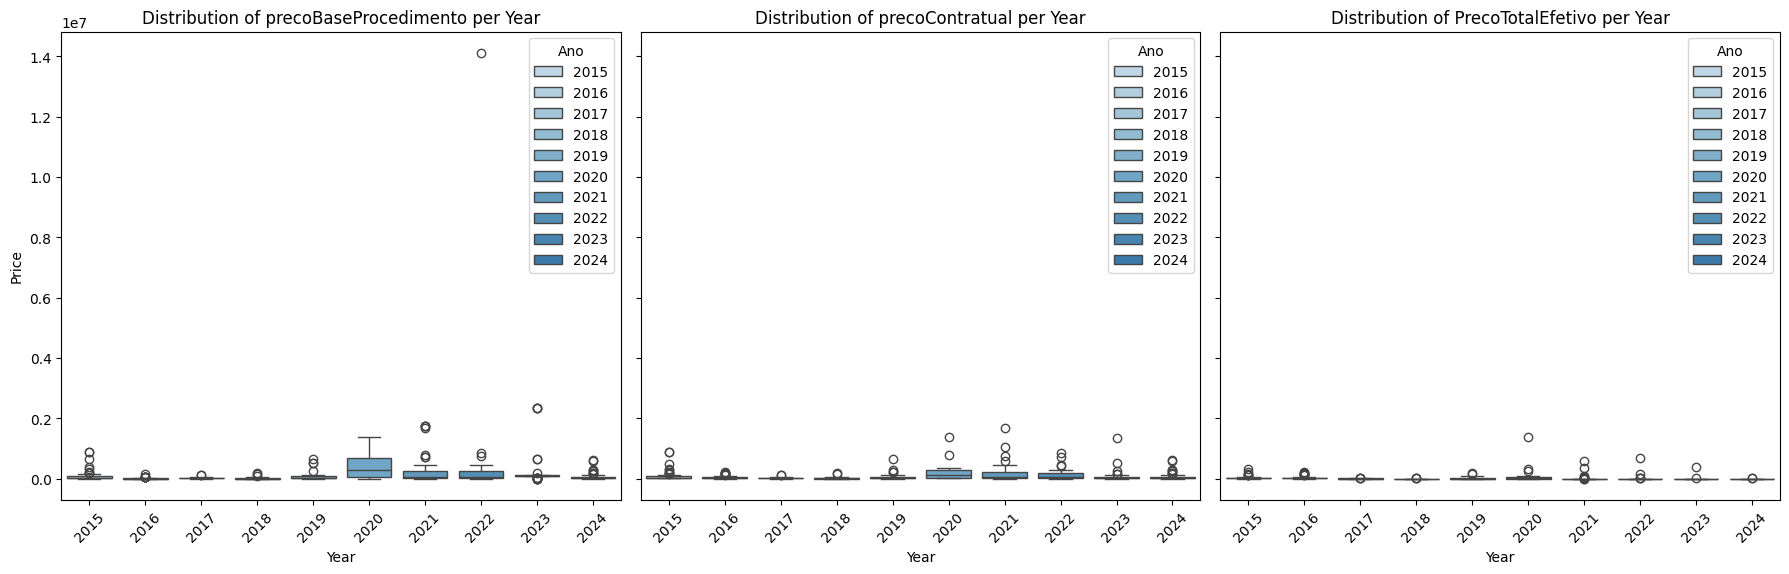

In [84]:
features = ['precoBaseProcedimento', 'precoContratual', 'PrecoTotalEfetivo']
fig, axs = plt.subplots(1, 3, figsize=(18, 6), sharex=True, sharey=True)

for ax, col in zip(axs, features):
    sns.boxplot(
        data=df_geral_contratos_79,
        x='Ano',
        y=col,
        palette=colors,
        hue='Ano',
        ax=ax
    )
    ax.set_title(f'Distribution of {col} per Year')
    ax.set_xlabel('Year')
    ax.set_ylabel('Price')
    ax.tick_params(axis='x', rotation=45)

plt.tight_layout()
plt.show()

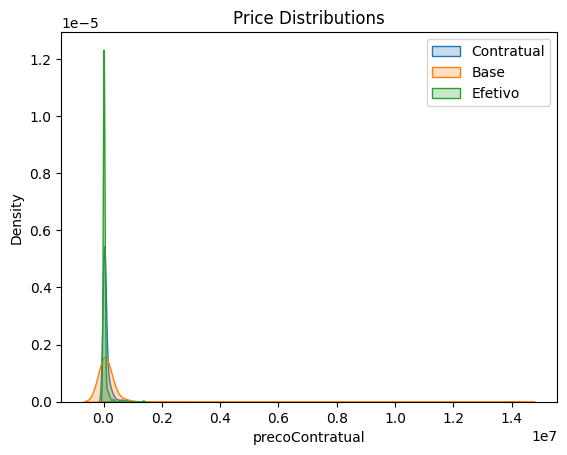

In [85]:
sns.kdeplot(df_geral_contratos_79['precoContratual'], label='Contratual', fill=True)
sns.kdeplot(df_geral_contratos_79['precoBaseProcedimento'], label='Base', fill=True)
sns.kdeplot(df_geral_contratos_79['PrecoTotalEfetivo'], label='Efetivo', fill=True)
plt.legend()
plt.title('Price Distributions')
plt.show()

# Outliers

In [86]:
def remove_outliers_iqr(df, columns):
    df_clean = df.copy()
    for col in columns:
        Q1 = df_clean[col].quantile(0.25)
        Q3 = df_clean[col].quantile(0.75)
        IQR = Q3 - Q1
        lower_bound = Q1 - 1.5 * IQR
        upper_bound = Q3 + 1.5 * IQR
        # Keep only the rows where the value is within the limits
        df_clean = df_clean[(df_clean[col] >= lower_bound) & (df_clean[col] <= upper_bound)]
    return df_clean

cols_to_check = ['precoContratual', 'precoBaseProcedimento', 'PrecoTotalEfetivo']
df_no_outliers = remove_outliers_iqr(df_geral_contratos_79, cols_to_check)
print(f"Before: {df_geral_contratos_79.shape[0]} rows")
print(f"After: {df_no_outliers.shape[0]} rows (outliers removed)")

Before: 414 rows
After: 307 rows (outliers removed)


# Charts without outliers

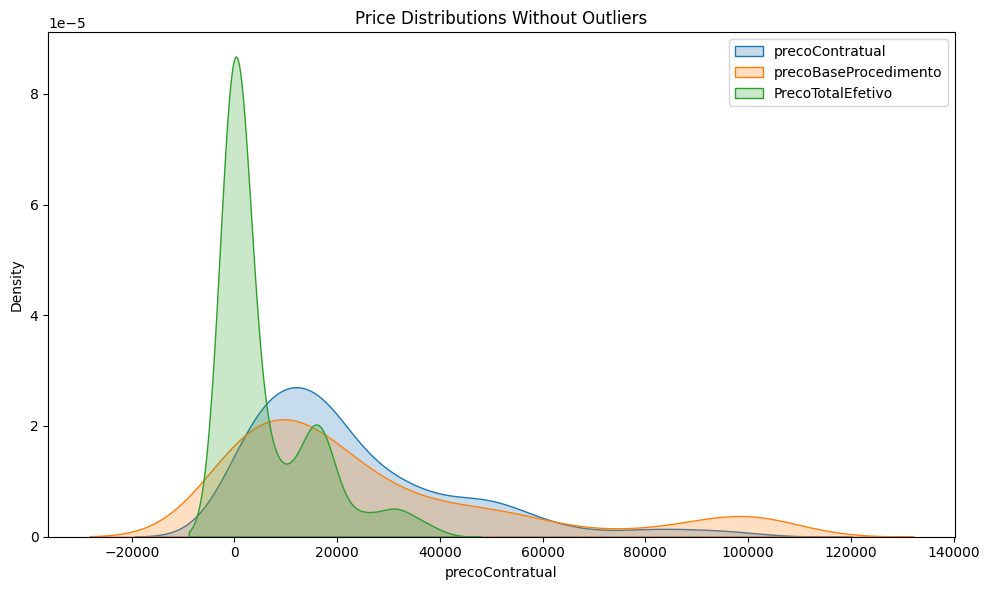

In [87]:
features = ['precoContratual', 'precoBaseProcedimento', 'PrecoTotalEfetivo']
plt.figure(figsize=(10,6))
for col in features:
    sns.kdeplot(
        data=df_no_outliers,
        x=col,
        fill=True,
        label=col
    )
plt.title('Price Distributions Without Outliers')
plt.legend()
plt.tight_layout()
plt.show()

# Updating Preço Contratual

In [88]:
# List some rows with the value zero or nan
df_geral_contratos_79.loc[:, 'precoContratual'] = pd.to_numeric(
    df_geral_contratos_79['precoContratual'], errors='coerce'
)
# Filter rows where the value is 0 or NaN
filtered_rows = df_geral_contratos_79[
    (df_geral_contratos_79['precoContratual'].isna()) |
    (df_geral_contratos_79['precoContratual'] == 0)
]
# Count the number of such rows
count = filtered_rows.shape[0]
# Display result
print(f"Number of rows with precoContratual = 0 or NaN/null: {count}")
display(filtered_rows.head(3))  # Show some sample rows

Number of rows with precoContratual = 0 or NaN/null: 1


,idcontrato,nAnuncio,TipoAnuncio,idINCM,tipoContrato,idprocedimento,tipoprocedimento,objectoContrato,descContrato,adjudicante,adjudicatarios,dataPublicacao,dataCelebracaoContrato,precoContratual,cpv,prazoExecucao,localExecucao,fundamentacao,ProcedimentoCentralizado,numAcordoQuadro,DescrAcordoQuadro,precoBaseProcedimento,dataDecisaoAdjudicacao,dataFechoContrato,PrecoTotalEfetivo,regime,justifNReducEscrContrato,tipoFimContrato,CritMateriais,concorrentes,linkPecasProc,Observacoes,ContratEcologico,Ano,fundamentAjusteDireto,adjudicante_string,adjudicante_nipc,adjudicante_description,adjudicatarios_string,adjudicatarios_nipc,adjudicatarios_description,dataPublicacaoParsed,anoPublicação,dataCelebracaoContratoParsed,anoDataCelebracaoContrato,precoContratualInterval,cpv_string,cpv_number,cpv_description,prazoExecucaoIntervalo,precoBaseProcedimentoInterval,dataDecisaoAdjudicacaoParsed,anoDataDecisaoAdjudicacao,dataFechoContratoParsed,anoDataFechoContrato,PrecoTotalEfetivoInterval,concorrentes_string,concorrentes_nipc,concorrentes_description,Fonte_Arquivo,tipoContrato_str
1034765,9203164,13840/2021,Anúncio de procedimento,414665937,"(Aquisição de serviços,)",5636315,Concurso público,Concurso Público para a celebração de Contratos Públicos de Aprovisionamento relativos à prestação de serviços médicos às Unidades de Saúde de Ilha do Serviço Regional de Saúde,Concurso Público para a celebração de Contratos Públicos de Aprovisionamento relativos à prestação de serviços médicos às Unidades de Saúde de Ilha do Serviço Regional de Saúde,"(600087174 - Direção Regional da Saúde,)",None,28/04/2022,06/04/2022,0.0,"(79625000-1 - Serviços de fornecimento de pessoal médico,)",1460,"(Portugal, Região Autónoma dos Açores,)","Artigo 33.º, n.º 1 do Código dos Contratos Públicos",True,<NA>,,14117972.0,02/03/2022,,0.0,"Código dos Contratos Públicos (DL 111-B/2017 ) e DLR nº 27/2015/A, de 29.12",<NA>,,False,"(513993274-Precise, SA, 506111148-KNOWER PROJECTS, S.A.)",https://www.acingov.pt/acingovprod/2/index.php/zonaPublica/zona_publica_c/donwloadProcedurePiece/NTE5MzEx,,False,2022,,['600087174 - Direção Regional da Saúde'],"(600087174,)","(Direção Regional da Saúde,)",<NA>,None,None,2022-04-28,2022,2022-04-06,2022.0,zero,['79625000-1 - Serviços de fornecimento de pessoal médico'],"(79625000-1,)","(Serviços de fornecimento de pessoal médico,)",1440-1469 dias,"Above 5,350,000 €",2022-03-02,2022.0,NaT,NaN,zero,"['513993274-Precise, SA' '506111148-KNOWER PROJECTS, S.A.']","(513993274, 506111148)","(Precise, SA, KNOWER PROJECTS, S.A.)",csv_resultados_2022.parquet,Aquisição de serviços


In [89]:
filtered_rows = df_geral_contratos_79[(df_geral_contratos_79['idcontrato']==9203164)]
display(filtered_rows)

,idcontrato,nAnuncio,TipoAnuncio,idINCM,tipoContrato,idprocedimento,tipoprocedimento,objectoContrato,descContrato,adjudicante,adjudicatarios,dataPublicacao,dataCelebracaoContrato,precoContratual,cpv,prazoExecucao,localExecucao,fundamentacao,ProcedimentoCentralizado,numAcordoQuadro,DescrAcordoQuadro,precoBaseProcedimento,dataDecisaoAdjudicacao,dataFechoContrato,PrecoTotalEfetivo,regime,justifNReducEscrContrato,tipoFimContrato,CritMateriais,concorrentes,linkPecasProc,Observacoes,ContratEcologico,Ano,fundamentAjusteDireto,adjudicante_string,adjudicante_nipc,adjudicante_description,adjudicatarios_string,adjudicatarios_nipc,adjudicatarios_description,dataPublicacaoParsed,anoPublicação,dataCelebracaoContratoParsed,anoDataCelebracaoContrato,precoContratualInterval,cpv_string,cpv_number,cpv_description,prazoExecucaoIntervalo,precoBaseProcedimentoInterval,dataDecisaoAdjudicacaoParsed,anoDataDecisaoAdjudicacao,dataFechoContratoParsed,anoDataFechoContrato,PrecoTotalEfetivoInterval,concorrentes_string,concorrentes_nipc,concorrentes_description,Fonte_Arquivo,tipoContrato_str
1034765,9203164,13840/2021,Anúncio de procedimento,414665937,"(Aquisição de serviços,)",5636315,Concurso público,Concurso Público para a celebração de Contratos Públicos de Aprovisionamento relativos à prestação de serviços médicos às Unidades de Saúde de Ilha do Serviço Regional de Saúde,Concurso Público para a celebração de Contratos Públicos de Aprovisionamento relativos à prestação de serviços médicos às Unidades de Saúde de Ilha do Serviço Regional de Saúde,"(600087174 - Direção Regional da Saúde,)",None,28/04/2022,06/04/2022,0.0,"(79625000-1 - Serviços de fornecimento de pessoal médico,)",1460,"(Portugal, Região Autónoma dos Açores,)","Artigo 33.º, n.º 1 do Código dos Contratos Públicos",True,<NA>,,14117972.0,02/03/2022,,0.0,"Código dos Contratos Públicos (DL 111-B/2017 ) e DLR nº 27/2015/A, de 29.12",<NA>,,False,"(513993274-Precise, SA, 506111148-KNOWER PROJECTS, S.A.)",https://www.acingov.pt/acingovprod/2/index.php/zonaPublica/zona_publica_c/donwloadProcedurePiece/NTE5MzEx,,False,2022,,['600087174 - Direção Regional da Saúde'],"(600087174,)","(Direção Regional da Saúde,)",<NA>,None,None,2022-04-28,2022,2022-04-06,2022.0,zero,['79625000-1 - Serviços de fornecimento de pessoal médico'],"(79625000-1,)","(Serviços de fornecimento de pessoal médico,)",1440-1469 dias,"Above 5,350,000 €",2022-03-02,2022.0,NaT,NaN,zero,"['513993274-Precise, SA' '506111148-KNOWER PROJECTS, S.A.']","(513993274, 506111148)","(Precise, SA, KNOWER PROJECTS, S.A.)",csv_resultados_2022.parquet,Aquisição de serviços


In [90]:
df_geral_contratos_79.loc[df_geral_contratos_79['idcontrato'] == 9203164, 'precoContratual'] = 12839441.24
df_geral_contratos_79['precoContratual'] = pd.to_numeric(df_geral_contratos_79['precoContratual'], errors='coerce')

In [91]:
filtered_rows = df_geral_contratos_79[(df_geral_contratos_79['idcontrato']==9203164)]
display(filtered_rows)

,idcontrato,nAnuncio,TipoAnuncio,idINCM,tipoContrato,idprocedimento,tipoprocedimento,objectoContrato,descContrato,adjudicante,adjudicatarios,dataPublicacao,dataCelebracaoContrato,precoContratual,cpv,prazoExecucao,localExecucao,fundamentacao,ProcedimentoCentralizado,numAcordoQuadro,DescrAcordoQuadro,precoBaseProcedimento,dataDecisaoAdjudicacao,dataFechoContrato,PrecoTotalEfetivo,regime,justifNReducEscrContrato,tipoFimContrato,CritMateriais,concorrentes,linkPecasProc,Observacoes,ContratEcologico,Ano,fundamentAjusteDireto,adjudicante_string,adjudicante_nipc,adjudicante_description,adjudicatarios_string,adjudicatarios_nipc,adjudicatarios_description,dataPublicacaoParsed,anoPublicação,dataCelebracaoContratoParsed,anoDataCelebracaoContrato,precoContratualInterval,cpv_string,cpv_number,cpv_description,prazoExecucaoIntervalo,precoBaseProcedimentoInterval,dataDecisaoAdjudicacaoParsed,anoDataDecisaoAdjudicacao,dataFechoContratoParsed,anoDataFechoContrato,PrecoTotalEfetivoInterval,concorrentes_string,concorrentes_nipc,concorrentes_description,Fonte_Arquivo,tipoContrato_str
1034765,9203164,13840/2021,Anúncio de procedimento,414665937,"(Aquisição de serviços,)",5636315,Concurso público,Concurso Público para a celebração de Contratos Públicos de Aprovisionamento relativos à prestação de serviços médicos às Unidades de Saúde de Ilha do Serviço Regional de Saúde,Concurso Público para a celebração de Contratos Públicos de Aprovisionamento relativos à prestação de serviços médicos às Unidades de Saúde de Ilha do Serviço Regional de Saúde,"(600087174 - Direção Regional da Saúde,)",None,28/04/2022,06/04/2022,12839441.24,"(79625000-1 - Serviços de fornecimento de pessoal médico,)",1460,"(Portugal, Região Autónoma dos Açores,)","Artigo 33.º, n.º 1 do Código dos Contratos Públicos",True,<NA>,,14117972.0,02/03/2022,,0.0,"Código dos Contratos Públicos (DL 111-B/2017 ) e DLR nº 27/2015/A, de 29.12",<NA>,,False,"(513993274-Precise, SA, 506111148-KNOWER PROJECTS, S.A.)",https://www.acingov.pt/acingovprod/2/index.php/zonaPublica/zona_publica_c/donwloadProcedurePiece/NTE5MzEx,,False,2022,,['600087174 - Direção Regional da Saúde'],"(600087174,)","(Direção Regional da Saúde,)",<NA>,None,None,2022-04-28,2022,2022-04-06,2022.0,zero,['79625000-1 - Serviços de fornecimento de pessoal médico'],"(79625000-1,)","(Serviços de fornecimento de pessoal médico,)",1440-1469 dias,"Above 5,350,000 €",2022-03-02,2022.0,NaT,NaN,zero,"['513993274-Precise, SA' '506111148-KNOWER PROJECTS, S.A.']","(513993274, 506111148)","(Precise, SA, KNOWER PROJECTS, S.A.)",csv_resultados_2022.parquet,Aquisição de serviços


In [92]:
filtered_rows = df_geral_contratos_79[(df_geral_contratos_79['idcontrato']==9203164)]
display(filtered_rows)

,idcontrato,nAnuncio,TipoAnuncio,idINCM,tipoContrato,idprocedimento,tipoprocedimento,objectoContrato,descContrato,adjudicante,adjudicatarios,dataPublicacao,dataCelebracaoContrato,precoContratual,cpv,prazoExecucao,localExecucao,fundamentacao,ProcedimentoCentralizado,numAcordoQuadro,DescrAcordoQuadro,precoBaseProcedimento,dataDecisaoAdjudicacao,dataFechoContrato,PrecoTotalEfetivo,regime,justifNReducEscrContrato,tipoFimContrato,CritMateriais,concorrentes,linkPecasProc,Observacoes,ContratEcologico,Ano,fundamentAjusteDireto,adjudicante_string,adjudicante_nipc,adjudicante_description,adjudicatarios_string,adjudicatarios_nipc,adjudicatarios_description,dataPublicacaoParsed,anoPublicação,dataCelebracaoContratoParsed,anoDataCelebracaoContrato,precoContratualInterval,cpv_string,cpv_number,cpv_description,prazoExecucaoIntervalo,precoBaseProcedimentoInterval,dataDecisaoAdjudicacaoParsed,anoDataDecisaoAdjudicacao,dataFechoContratoParsed,anoDataFechoContrato,PrecoTotalEfetivoInterval,concorrentes_string,concorrentes_nipc,concorrentes_description,Fonte_Arquivo,tipoContrato_str
1034765,9203164,13840/2021,Anúncio de procedimento,414665937,"(Aquisição de serviços,)",5636315,Concurso público,Concurso Público para a celebração de Contratos Públicos de Aprovisionamento relativos à prestação de serviços médicos às Unidades de Saúde de Ilha do Serviço Regional de Saúde,Concurso Público para a celebração de Contratos Públicos de Aprovisionamento relativos à prestação de serviços médicos às Unidades de Saúde de Ilha do Serviço Regional de Saúde,"(600087174 - Direção Regional da Saúde,)",None,28/04/2022,06/04/2022,12839441.24,"(79625000-1 - Serviços de fornecimento de pessoal médico,)",1460,"(Portugal, Região Autónoma dos Açores,)","Artigo 33.º, n.º 1 do Código dos Contratos Públicos",True,<NA>,,14117972.0,02/03/2022,,0.0,"Código dos Contratos Públicos (DL 111-B/2017 ) e DLR nº 27/2015/A, de 29.12",<NA>,,False,"(513993274-Precise, SA, 506111148-KNOWER PROJECTS, S.A.)",https://www.acingov.pt/acingovprod/2/index.php/zonaPublica/zona_publica_c/donwloadProcedurePiece/NTE5MzEx,,False,2022,,['600087174 - Direção Regional da Saúde'],"(600087174,)","(Direção Regional da Saúde,)",<NA>,None,None,2022-04-28,2022,2022-04-06,2022.0,zero,['79625000-1 - Serviços de fornecimento de pessoal médico'],"(79625000-1,)","(Serviços de fornecimento de pessoal médico,)",1440-1469 dias,"Above 5,350,000 €",2022-03-02,2022.0,NaT,NaN,zero,"['513993274-Precise, SA' '506111148-KNOWER PROJECTS, S.A.']","(513993274, 506111148)","(Precise, SA, KNOWER PROJECTS, S.A.)",csv_resultados_2022.parquet,Aquisição de serviços


# Contracts with more than one CPV

In [93]:
# Verificar se há valores None ou NaN
missing_cpvs = df_geral_contratos_79['cpv_number'].isnull().sum()
print(f"Número de valores None/NaN: {missing_cpvs}")

# Verificar se há listas com mais de um CPV
multivalued_cpvs = df_geral_contratos_79['cpv_number'].apply(
    lambda x: isinstance(x, (list, tuple)) and len(x) > 1
).sum()
print(f"Número de listas com mais de um CPV: {multivalued_cpvs}")

Número de valores None/NaN: 0
Número de listas com mais de um CPV: 5


In [94]:
examples = df_geral_contratos_79[df_geral_contratos_79['cpv_number'].apply(lambda x: isinstance(x, (list, tuple)) and len(x) > 1)]
display(examples.head())

,idcontrato,nAnuncio,TipoAnuncio,idINCM,tipoContrato,idprocedimento,tipoprocedimento,objectoContrato,descContrato,adjudicante,adjudicatarios,dataPublicacao,dataCelebracaoContrato,precoContratual,cpv,prazoExecucao,localExecucao,fundamentacao,ProcedimentoCentralizado,numAcordoQuadro,DescrAcordoQuadro,precoBaseProcedimento,dataDecisaoAdjudicacao,dataFechoContrato,PrecoTotalEfetivo,regime,justifNReducEscrContrato,tipoFimContrato,CritMateriais,concorrentes,linkPecasProc,Observacoes,ContratEcologico,Ano,fundamentAjusteDireto,adjudicante_string,adjudicante_nipc,adjudicante_description,adjudicatarios_string,adjudicatarios_nipc,adjudicatarios_description,dataPublicacaoParsed,anoPublicação,dataCelebracaoContratoParsed,anoDataCelebracaoContrato,precoContratualInterval,cpv_string,cpv_number,cpv_description,prazoExecucaoIntervalo,precoBaseProcedimentoInterval,dataDecisaoAdjudicacaoParsed,anoDataDecisaoAdjudicacao,dataFechoContratoParsed,anoDataFechoContrato,PrecoTotalEfetivoInterval,concorrentes_string,concorrentes_nipc,concorrentes_description,Fonte_Arquivo,tipoContrato_str
1168664,9722622,14788/2022,Anúncio de procedimento,415876141,"(Aquisição de serviços,)",6142877,Concurso público,AQUISIÇÃO DE SERVIÇOS MÉDICOS E DE ENFERMAGEM HFAR PL E PP,AQUISIÇÃO DE SERVIÇOS MÉDICOS E DE ENFERMAGEM HFAR PL E PP,"(600010180 - Estado-Maior-General das Forças Armadas (EMGFA),)","(506111148 - KNOWER PROJECTS, S.A.,)",20/01/2023,01/01/2023,21248.40,"(79625000-1 - Serviços de fornecimento de pessoal médico, 79624000-4 - Serviços de fornecimento de pessoal de enfermagem)",31,"(Portugal,)","Artigo 20.º, n.º 1, alínea b) do Código dos Contratos Públicos",False,<NA>,,97892.0,27/12/2022,,0.0,"Código dos Contratos Públicos (DL111-B/2017) e Lei n.º 30/2021, de 21.05",<NA>,,False,"(506111148-Knower Projects, S.A., 513074619-Medaute, 516891642-CAROLINABP, LDA, 501356550-SOUSA FILIPE LDA)",https://www.acingov.pt/acingovprod/2/index.php/zonaPublica/zona_publica_c/donwloadProcedurePiece/NTg5Njky,,False,2023,,['600010180 - Estado-Maior-General das Forças Armadas (EMGFA)'],"(600010180,)","(Estado-Maior-General das Forças Armadas (EMGFA),)","['506111148 - KNOWER PROJECTS, S.A.']","(506111148,)","(KNOWER PROJECTS, S.A.,)",2023-01-20,2023,2023-01-01,2023.0,"5,001 € to 50,000 €",['79625000-1 - Serviços de fornecimento de pessoal médico' '79624000-4 - Serviços de fornecimento de pessoal de enfermagem'],"(79625000-1, 79624000-4)","(Serviços de fornecimento de pessoal médico, Serviços de fornecimento de pessoal de enfermagem)",30-59 dias,"50,001 € to 139,000 €",2022-12-27,2022.0,NaT,NaN,zero,"['506111148-Knower Projects, S.A.' '513074619-Medaute' '516891642-CAROLINABP, LDA' '501356550-SOUSA FILIPE LDA']","(506111148, 513074619, 516891642, 501356550)","(Knower Projects, S.A., Medaute, CAROLINABP, LDA, SOUSA FILIPE LDA)",csv_resultados_2023.parquet,Aquisição de serviços
1181003,9824036,22/2023,Anúncio de concurso urgente,416070176,"(Aquisição de serviços,)",6277746,Concurso público,Aquisição de Serviços Médicos e Enfermagem para HFAR PL e PP,Aquisição de Serviços Médicos e Enfermagem para HFAR PL e PP,"(600010180 - Estado-Maior-General das Forças Armadas (EMGFA),)","(510723691 - Kelly Services Healthcare, Unipessoal, Lda,)",27/02/2023,01/02/2023,16823.04,"(79624000-4 - Serviços de fornecimento de pessoal de enfermagem, 79625000-1 - Serviços de fornecimento de pessoal médico)",28,"(Portugal,)","Artigo 155.º, alínea a) do Código dos Contratos Públicos",False,<NA>,,97892.0,27/01/2023,,0.0,"Código dos Contratos Públicos (DL111-B/2017) e Lei n.º 30/2021, de 21.05",<NA>,,False,"(510723691-Kelly Services Healthcare, Unipessoal, Lda, 506111148-KNOWER PROJECTS, S.A., 513074619-Medaute, 504264117-I A PATRICIO PRESTAÇÃO SERVIÇOS DE SAUDE, 516891642-carolinabp, Lda, 501356550-SOUSA FILIPE,Lda )",https://www.acingov.pt/acingovprod/2/index.php/zonaPublica/zona_publica_c/donwloadProcedurePiece/NjAzMDQ4,,False,2023,,['600010180 - Estado-Maior-General das Forças Armadas (EMGFA)'],"(600010180,)"

### Contrato 1

In [95]:
filtered_rows = df_geral_contratos_79[(df_geral_contratos_79['idcontrato']==9722622)]
display(filtered_rows)

,idcontrato,nAnuncio,TipoAnuncio,idINCM,tipoContrato,idprocedimento,tipoprocedimento,objectoContrato,descContrato,adjudicante,adjudicatarios,dataPublicacao,dataCelebracaoContrato,precoContratual,cpv,prazoExecucao,localExecucao,fundamentacao,ProcedimentoCentralizado,numAcordoQuadro,DescrAcordoQuadro,precoBaseProcedimento,dataDecisaoAdjudicacao,dataFechoContrato,PrecoTotalEfetivo,regime,justifNReducEscrContrato,tipoFimContrato,CritMateriais,concorrentes,linkPecasProc,Observacoes,ContratEcologico,Ano,fundamentAjusteDireto,adjudicante_string,adjudicante_nipc,adjudicante_description,adjudicatarios_string,adjudicatarios_nipc,adjudicatarios_description,dataPublicacaoParsed,anoPublicação,dataCelebracaoContratoParsed,anoDataCelebracaoContrato,precoContratualInterval,cpv_string,cpv_number,cpv_description,prazoExecucaoIntervalo,precoBaseProcedimentoInterval,dataDecisaoAdjudicacaoParsed,anoDataDecisaoAdjudicacao,dataFechoContratoParsed,anoDataFechoContrato,PrecoTotalEfetivoInterval,concorrentes_string,concorrentes_nipc,concorrentes_description,Fonte_Arquivo,tipoContrato_str
1168664,9722622,14788/2022,Anúncio de procedimento,415876141,"(Aquisição de serviços,)",6142877,Concurso público,AQUISIÇÃO DE SERVIÇOS MÉDICOS E DE ENFERMAGEM HFAR PL E PP,AQUISIÇÃO DE SERVIÇOS MÉDICOS E DE ENFERMAGEM HFAR PL E PP,"(600010180 - Estado-Maior-General das Forças Armadas (EMGFA),)","(506111148 - KNOWER PROJECTS, S.A.,)",20/01/2023,01/01/2023,21248.4,"(79625000-1 - Serviços de fornecimento de pessoal médico, 79624000-4 - Serviços de fornecimento de pessoal de enfermagem)",31,"(Portugal,)","Artigo 20.º, n.º 1, alínea b) do Código dos Contratos Públicos",False,<NA>,,97892.0,27/12/2022,,0.0,"Código dos Contratos Públicos (DL111-B/2017) e Lei n.º 30/2021, de 21.05",<NA>,,False,"(506111148-Knower Projects, S.A., 513074619-Medaute, 516891642-CAROLINABP, LDA, 501356550-SOUSA FILIPE LDA)",https://www.acingov.pt/acingovprod/2/index.php/zonaPublica/zona_publica_c/donwloadProcedurePiece/NTg5Njky,,False,2023,,['600010180 - Estado-Maior-General das Forças Armadas (EMGFA)'],"(600010180,)","(Estado-Maior-General das Forças Armadas (EMGFA),)","['506111148 - KNOWER PROJECTS, S.A.']","(506111148,)","(KNOWER PROJECTS, S.A.,)",2023-01-20,2023,2023-01-01,2023.0,"5,001 € to 50,000 €",['79625000-1 - Serviços de fornecimento de pessoal médico' '79624000-4 - Serviços de fornecimento de pessoal de enfermagem'],"(79625000-1, 79624000-4)","(Serviços de fornecimento de pessoal médico, Serviços de fornecimento de pessoal de enfermagem)",30-59 dias,"50,001 € to 139,000 €",2022-12-27,2022.0,NaT,NaN,zero,"['506111148-Knower Projects, S.A.' '513074619-Medaute' '516891642-CAROLINABP, LDA' '501356550-SOUSA FILIPE LDA']","(506111148, 513074619, 516891642, 501356550)","(Knower Projects, S.A., Medaute, CAROLINABP, LDA, SOUSA FILIPE LDA)",csv_resultados_2023.parquet,Aquisição de serviços


In [96]:
# filter original row
filtered_row = df_geral_contratos_79[df_geral_contratos_79['idcontrato'] == 9722622]

# verify the row existence
if not filtered_row.empty:
    # Criar duas cópias
    row_medicine = filtered_row.copy()
    row_nursing = filtered_row.copy()

    # update medicine values
    row_medicine['cpv'] = '(79625000-1 - Serviços de fornecimento de pessoal médico,)'
    row_medicine['cpv_string'] = "['79625000-1 - Serviços de fornecimento de pessoal médico']"
    row_medicine['cpv_number'] = "(79625000-1,)"
    row_medicine['cpv_description'] = "(Serviços de fornecimento de pessoal médico,)"
    row_medicine['precoContratual'] = 10338.80

    # update nursing values
    row_nursing['cpv'] = "(79624000-4 - Serviços de fornecimento de pessoal de enfermagem,)"
    row_nursing['cpv_string'] = "['79624000-4 - Serviços de fornecimento de pessoal de enfermagem']"
    row_nursing['cpv_number'] = "(79624000-4,)"
    row_nursing['cpv_description'] = "(Serviços de fornecimento de pessoal de enfermagem,)"
    row_nursing['precoContratual'] = 10859.60

    # delete original row
    df_geral_contratos_79 = df_geral_contratos_79[df_geral_contratos_79['idcontrato'] != 9722622]

    # add the two nes rows
    df_geral_contratos_79 = pd.concat([df_geral_contratos_79, row_medicine, row_nursing], ignore_index=True)

else:
    print("Linha com idcontrato == 9722622 não encontrada.")

In [97]:
filtered_rows = df_geral_contratos_79[(df_geral_contratos_79['idcontrato']==9722622)]
display(filtered_rows)

,idcontrato,nAnuncio,TipoAnuncio,idINCM,tipoContrato,idprocedimento,tipoprocedimento,objectoContrato,descContrato,adjudicante,adjudicatarios,dataPublicacao,dataCelebracaoContrato,precoContratual,cpv,prazoExecucao,localExecucao,fundamentacao,ProcedimentoCentralizado,numAcordoQuadro,DescrAcordoQuadro,precoBaseProcedimento,dataDecisaoAdjudicacao,dataFechoContrato,PrecoTotalEfetivo,regime,justifNReducEscrContrato,tipoFimContrato,CritMateriais,concorrentes,linkPecasProc,Observacoes,ContratEcologico,Ano,fundamentAjusteDireto,adjudicante_string,adjudicante_nipc,adjudicante_description,adjudicatarios_string,adjudicatarios_nipc,adjudicatarios_description,dataPublicacaoParsed,anoPublicação,dataCelebracaoContratoParsed,anoDataCelebracaoContrato,precoContratualInterval,cpv_string,cpv_number,cpv_description,prazoExecucaoIntervalo,precoBaseProcedimentoInterval,dataDecisaoAdjudicacaoParsed,anoDataDecisaoAdjudicacao,dataFechoContratoParsed,anoDataFechoContrato,PrecoTotalEfetivoInterval,concorrentes_string,concorrentes_nipc,concorrentes_description,Fonte_Arquivo,tipoContrato_str
413,9722622,14788/2022,Anúncio de procedimento,415876141,"(Aquisição de serviços,)",6142877,Concurso público,AQUISIÇÃO DE SERVIÇOS MÉDICOS E DE ENFERMAGEM HFAR PL E PP,AQUISIÇÃO DE SERVIÇOS MÉDICOS E DE ENFERMAGEM HFAR PL E PP,"(600010180 - Estado-Maior-General das Forças Armadas (EMGFA),)","(506111148 - KNOWER PROJECTS, S.A.,)",20/01/2023,01/01/2023,10338.8,"(79625000-1 - Serviços de fornecimento de pessoal médico,)",31,"(Portugal,)","Artigo 20.º, n.º 1, alínea b) do Código dos Contratos Públicos",False,<NA>,,97892.0,27/12/2022,,0.0,"Código dos Contratos Públicos (DL111-B/2017) e Lei n.º 30/2021, de 21.05",<NA>,,False,"(506111148-Knower Projects, S.A., 513074619-Medaute, 516891642-CAROLINABP, LDA, 501356550-SOUSA FILIPE LDA)",https://www.acingov.pt/acingovprod/2/index.php/zonaPublica/zona_publica_c/donwloadProcedurePiece/NTg5Njky,,False,2023,,['600010180 - Estado-Maior-General das Forças Armadas (EMGFA)'],"(600010180,)","(Estado-Maior-General das Forças Armadas (EMGFA),)","['506111148 - KNOWER PROJECTS, S.A.']","(506111148,)","(KNOWER PROJECTS, S.A.,)",2023-01-20,2023,2023-01-01,2023.0,"5,001 € to 50,000 €",['79625000-1 - Serviços de fornecimento de pessoal médico'],"(79625000-1,)","(Serviços de fornecimento de pessoal médico,)",30-59 dias,"50,001 € to 139,000 €",2022-12-27,2022.0,NaT,NaN,zero,"['506111148-Knower Projects, S.A.' '513074619-Medaute' '516891642-CAROLINABP, LDA' '501356550-SOUSA FILIPE LDA']","(506111148, 513074619, 516891642, 501356550)","(Knower Projects, S.A., Medaute, CAROLINABP, LDA, SOUSA FILIPE LDA)",csv_resultados_2023.parquet,Aquisição de serviços
414,9722622,14788/2022,Anúncio de procedimento,415876141,"(Aquisição de serviços,)",6142877,Concurso público,AQUISIÇÃO DE SERVIÇOS MÉDICOS E DE ENFERMAGEM HFAR PL E PP,AQUISIÇÃO DE SERVIÇOS MÉDICOS E DE ENFERMAGEM HFAR PL E PP,"(600010180 - Estado-Maior-General das Forças Armadas (EMGFA),)","(506111148 - KNOWER PROJECTS, S.A.,)",20/01/2023,01/01/2023,10859.6,"(79624000-4 - Serviços de fornecimento de pessoal de enfermagem,)",31,"(Portugal,)","Artigo 20.º, n.º 1, alínea b) do Código dos Contratos Públicos",False,<NA>,,97892.0,27/12/2022,,0.0,"Código dos Contratos Públicos (DL111-B/2017) e Lei n.º 30/2021, de 21.05",<NA>,,False,"(506111148-Knower Projects, S.A., 513074619-Medaute, 516891642-CAROLINABP, LDA, 501356550-SOUSA FILIPE LDA)",https://www.acingov.pt/acingovprod/2/index.php/zonaPublica/zona_publica_c/donwloadProcedurePiece/NTg5Njky,,False,2023,,['600010180 - Estado-Maior-General das Forças Armadas (EMGFA)'],"(600010180,)","(Estado-Maior-General das Forças Armadas (EMGFA),)","['506111148 - KNOWER PROJECTS, S.A.']","(506111148,)","(KNOWER PROJECTS, S.A.,)",2023-01-20,2023,2023-01-01,2023.0,"5,001 € to 50,000 €",['79624000-4 - Serviços de fornecimento de pessoal de enfermagem'],"(79624000-4,)","(Serviços de fornecimento de pessoal de enfermagem,)",30-59 dias,"50,001 € to 139,000 €",2022-12-27,2022.0

### Contrato 2

In [98]:
filtered_rows = df_geral_contratos_79[(df_geral_contratos_79['idcontrato']==9824036)]
display(filtered_rows)

,idcontrato,nAnuncio,TipoAnuncio,idINCM,tipoContrato,idprocedimento,tipoprocedimento,objectoContrato,descContrato,adjudicante,adjudicatarios,dataPublicacao,dataCelebracaoContrato,precoContratual,cpv,prazoExecucao,localExecucao,fundamentacao,ProcedimentoCentralizado,numAcordoQuadro,DescrAcordoQuadro,precoBaseProcedimento,dataDecisaoAdjudicacao,dataFechoContrato,PrecoTotalEfetivo,regime,justifNReducEscrContrato,tipoFimContrato,CritMateriais,concorrentes,linkPecasProc,Observacoes,ContratEcologico,Ano,fundamentAjusteDireto,adjudicante_string,adjudicante_nipc,adjudicante_description,adjudicatarios_string,adjudicatarios_nipc,adjudicatarios_description,dataPublicacaoParsed,anoPublicação,dataCelebracaoContratoParsed,anoDataCelebracaoContrato,precoContratualInterval,cpv_string,cpv_number,cpv_description,prazoExecucaoIntervalo,precoBaseProcedimentoInterval,dataDecisaoAdjudicacaoParsed,anoDataDecisaoAdjudicacao,dataFechoContratoParsed,anoDataFechoContrato,PrecoTotalEfetivoInterval,concorrentes_string,concorrentes_nipc,concorrentes_description,Fonte_Arquivo,tipoContrato_str
326,9824036,22/2023,Anúncio de concurso urgente,416070176,"(Aquisição de serviços,)",6277746,Concurso público,Aquisição de Serviços Médicos e Enfermagem para HFAR PL e PP,Aquisição de Serviços Médicos e Enfermagem para HFAR PL e PP,"(600010180 - Estado-Maior-General das Forças Armadas (EMGFA),)","(510723691 - Kelly Services Healthcare, Unipessoal, Lda,)",27/02/2023,01/02/2023,16823.04,"(79624000-4 - Serviços de fornecimento de pessoal de enfermagem, 79625000-1 - Serviços de fornecimento de pessoal médico)",28,"(Portugal,)","Artigo 155.º, alínea a) do Código dos Contratos Públicos",False,<NA>,,97892.0,27/01/2023,,0.0,"Código dos Contratos Públicos (DL111-B/2017) e Lei n.º 30/2021, de 21.05",<NA>,,False,"(510723691-Kelly Services Healthcare, Unipessoal, Lda, 506111148-KNOWER PROJECTS, S.A., 513074619-Medaute, 504264117-I A PATRICIO PRESTAÇÃO SERVIÇOS DE SAUDE, 516891642-carolinabp, Lda, 501356550-SOUSA FILIPE,Lda )",https://www.acingov.pt/acingovprod/2/index.php/zonaPublica/zona_publica_c/donwloadProcedurePiece/NjAzMDQ4,,False,2023,,['600010180 - Estado-Maior-General das Forças Armadas (EMGFA)'],"(600010180,)","(Estado-Maior-General das Forças Armadas (EMGFA),)","['510723691 - Kelly Services Healthcare, Unipessoal, Lda']","(510723691,)","(Kelly Services Healthcare, Unipessoal, Lda,)",2023-02-27,2023,2023-02-01,2023.0,"5,001 € to 50,000 €",['79624000-4 - Serviços de fornecimento de pessoal de enfermagem'\n '79625000-1 - Serviços de fornecimento de pessoal médico'],"(79624000-4, 79625000-1)","(Serviços de fornecimento de pessoal de enfermagem, Serviços de fornecimento de pessoal médico)",0-29 dias,"50,001 € to 139,000 €",2023-01-27,2023.0,NaT,NaN,zero,"['510723691-Kelly Services Healthcare, Unipessoal, Lda' '506111148-KNOWER PROJECTS, S.A.' '513074619-Medaute' '504264117-I A PATRICIO PRESTAÇÃO SERVIÇOS DE SAUDE' '516891642-carolinabp, Lda' '501356550-SOUSA FILIPE,Lda ']","(510723691, 506111148, 513074619, 504264117, 516891642, 501356550)","(Kelly Services Healthcare, Unipessoal, Lda, KNOWER PROJECTS, S.A., Medaute, I A PATRICIO PRESTAÇÃO SERVIÇOS DE SAUDE, carolinabp, Lda, SOUSA FILIPE,Lda)",csv_resultados_2023.parquet,Aquisição de serviços


In [99]:
# filter original row
filtered_row = df_geral_contratos_79[df_geral_contratos_79['idcontrato'] == 9824036]

# verify the row existence
if not filtered_row.empty:
    # Criar duas cópias
    row_medicine = filtered_row.copy()
    row_nursing = filtered_row.copy()

    # update medicine values
    row_medicine['cpv'] = '(79625000-1 - Serviços de fornecimento de pessoal médico,)'
    row_medicine['cpv_string'] = "['79625000-1 - Serviços de fornecimento de pessoal médico']"
    row_medicine['cpv_number'] = "(79625000-1,)"
    row_medicine['cpv_description'] = "(Serviços de fornecimento de pessoal médico,)"
    row_medicine['precoContratual'] = 5895.36

    # update nursing values
    row_nursing['cpv'] = "(79624000-4 - Serviços de fornecimento de pessoal de enfermagem,)"
    row_nursing['cpv_string'] = "['79624000-4 - Serviços de fornecimento de pessoal de enfermagem']"
    row_nursing['cpv_number'] = "(79624000-4,)"
    row_nursing['cpv_description'] = "(Serviços de fornecimento de pessoal de enfermagem,)"
    row_nursing['precoContratual'] = 16823.04

    # delete original row
    df_geral_contratos_79 = df_geral_contratos_79[df_geral_contratos_79['idcontrato'] != 9824036]

    # add the two nes rows
    df_geral_contratos_79 = pd.concat([df_geral_contratos_79, row_medicine, row_nursing], ignore_index=True)

else:
    print("Linha com idcontrato == 9824036 não encontrada.")

In [100]:
filtered_rows = df_geral_contratos_79[(df_geral_contratos_79['idcontrato']==9824036)]
display(filtered_rows)

,idcontrato,nAnuncio,TipoAnuncio,idINCM,tipoContrato,idprocedimento,tipoprocedimento,objectoContrato,descContrato,adjudicante,adjudicatarios,dataPublicacao,dataCelebracaoContrato,precoContratual,cpv,prazoExecucao,localExecucao,fundamentacao,ProcedimentoCentralizado,numAcordoQuadro,DescrAcordoQuadro,precoBaseProcedimento,dataDecisaoAdjudicacao,dataFechoContrato,PrecoTotalEfetivo,regime,justifNReducEscrContrato,tipoFimContrato,CritMateriais,concorrentes,linkPecasProc,Observacoes,ContratEcologico,Ano,fundamentAjusteDireto,adjudicante_string,adjudicante_nipc,adjudicante_description,adjudicatarios_string,adjudicatarios_nipc,adjudicatarios_description,dataPublicacaoParsed,anoPublicação,dataCelebracaoContratoParsed,anoDataCelebracaoContrato,precoContratualInterval,cpv_string,cpv_number,cpv_description,prazoExecucaoIntervalo,precoBaseProcedimentoInterval,dataDecisaoAdjudicacaoParsed,anoDataDecisaoAdjudicacao,dataFechoContratoParsed,anoDataFechoContrato,PrecoTotalEfetivoInterval,concorrentes_string,concorrentes_nipc,concorrentes_description,Fonte_Arquivo,tipoContrato_str
414,9824036,22/2023,Anúncio de concurso urgente,416070176,"(Aquisição de serviços,)",6277746,Concurso público,Aquisição de Serviços Médicos e Enfermagem para HFAR PL e PP,Aquisição de Serviços Médicos e Enfermagem para HFAR PL e PP,"(600010180 - Estado-Maior-General das Forças Armadas (EMGFA),)","(510723691 - Kelly Services Healthcare, Unipessoal, Lda,)",27/02/2023,01/02/2023,5895.36,"(79625000-1 - Serviços de fornecimento de pessoal médico,)",28,"(Portugal,)","Artigo 155.º, alínea a) do Código dos Contratos Públicos",False,<NA>,,97892.0,27/01/2023,,0.0,"Código dos Contratos Públicos (DL111-B/2017) e Lei n.º 30/2021, de 21.05",<NA>,,False,"(510723691-Kelly Services Healthcare, Unipessoal, Lda, 506111148-KNOWER PROJECTS, S.A., 513074619-Medaute, 504264117-I A PATRICIO PRESTAÇÃO SERVIÇOS DE SAUDE, 516891642-carolinabp, Lda, 501356550-SOUSA FILIPE,Lda )",https://www.acingov.pt/acingovprod/2/index.php/zonaPublica/zona_publica_c/donwloadProcedurePiece/NjAzMDQ4,,False,2023,,['600010180 - Estado-Maior-General das Forças Armadas (EMGFA)'],"(600010180,)","(Estado-Maior-General das Forças Armadas (EMGFA),)","['510723691 - Kelly Services Healthcare, Unipessoal, Lda']","(510723691,)","(Kelly Services Healthcare, Unipessoal, Lda,)",2023-02-27,2023,2023-02-01,2023.0,"5,001 € to 50,000 €",['79625000-1 - Serviços de fornecimento de pessoal médico'],"(79625000-1,)","(Serviços de fornecimento de pessoal médico,)",0-29 dias,"50,001 € to 139,000 €",2023-01-27,2023.0,NaT,NaN,zero,"['510723691-Kelly Services Healthcare, Unipessoal, Lda' '506111148-KNOWER PROJECTS, S.A.' '513074619-Medaute' '504264117-I A PATRICIO PRESTAÇÃO SERVIÇOS DE SAUDE' '516891642-carolinabp, Lda' '501356550-SOUSA FILIPE,Lda ']","(510723691, 506111148, 513074619, 504264117, 516891642, 501356550)","(Kelly Services Healthcare, Unipessoal, Lda, KNOWER PROJECTS, S.A., Medaute, I A PATRICIO PRESTAÇÃO SERVIÇOS DE SAUDE, carolinabp, Lda, SOUSA FILIPE,Lda)",csv_resultados_2023.parquet,Aquisição de serviços
415,9824036,22/2023,Anúncio de concurso urgente,416070176,"(Aquisição de serviços,)",6277746,Concurso público,Aquisição de Serviços Médicos e Enfermagem para HFAR PL e PP,Aquisição de Serviços Médicos e Enfermagem para HFAR PL e PP,"(600010180 - Estado-Maior-General das Forças Armadas (EMGFA),)","(510723691 - Kelly Services Healthcare, Unipessoal, Lda,)",27/02/2023,01/02/2023,16823.04,"(79624000-4 - Serviços de fornecimento de pessoal de enfermagem,)",28,"(Portugal,)","Artigo 155.º, alínea a) do Código dos Contratos Públicos",False,<NA>,,97892.0,27/01/2023,,0.0,"Código dos Contratos Públicos (DL111-B/2017) e Lei n.º 30/2021, de 21.05",<NA>,,False,"(510723691-Kelly Services Healthcare, Unipessoal, Lda, 506111148-KNOWER PROJECTS, S.A., 513074619-Medaute, 504264117-I A PATRICIO PRESTAÇÃO SERVIÇOS DE SAUDE, 516891642-carolinabp, Lda, 501356550-SOUSA FILIPE,Lda )",https://www.acingov.pt/acingovprod/2/index.php/zonaPublica/zona_pu

### Contrato 3

In [101]:
filtered_rows = df_geral_contratos_79[(df_geral_contratos_79['idcontrato']==9876962)]
display(filtered_rows)

,idcontrato,nAnuncio,TipoAnuncio,idINCM,tipoContrato,idprocedimento,tipoprocedimento,objectoContrato,descContrato,adjudicante,adjudicatarios,dataPublicacao,dataCelebracaoContrato,precoContratual,cpv,prazoExecucao,localExecucao,fundamentacao,ProcedimentoCentralizado,numAcordoQuadro,DescrAcordoQuadro,precoBaseProcedimento,dataDecisaoAdjudicacao,dataFechoContrato,PrecoTotalEfetivo,regime,justifNReducEscrContrato,tipoFimContrato,CritMateriais,concorrentes,linkPecasProc,Observacoes,ContratEcologico,Ano,fundamentAjusteDireto,adjudicante_string,adjudicante_nipc,adjudicante_description,adjudicatarios_string,adjudicatarios_nipc,adjudicatarios_description,dataPublicacaoParsed,anoPublicação,dataCelebracaoContratoParsed,anoDataCelebracaoContrato,precoContratualInterval,cpv_string,cpv_number,cpv_description,prazoExecucaoIntervalo,precoBaseProcedimentoInterval,dataDecisaoAdjudicacaoParsed,anoDataDecisaoAdjudicacao,dataFechoContratoParsed,anoDataFechoContrato,PrecoTotalEfetivoInterval,concorrentes_string,concorrentes_nipc,concorrentes_description,Fonte_Arquivo,tipoContrato_str
327,9876962,96/2023,Anúncio de concurso urgente,416193078,"(Aquisição de serviços,)",6353665,Concurso público,Aquisição de Serviços Médicos e Enfermagem HFAR PL e PP março 2023,Aquisição de Serviços Médicos e Enfermagem HFAR PL e PP março 2023,"(600010180 - ESTADO-MAIOR-GENERAL DAS FORÇAS ARMADAS,)","(513074619 - Medaute,)",22/03/2023,20/03/2023,42280.08,"(79625000-1 - Serviços de fornecimento de pessoal médico, 79624000-4 - Serviços de fornecimento de pessoal de enfermagem)",31,"(Portugal,)","Artigo 155.º, alínea a) do Código dos Contratos Públicos",False,<NA>,,103964.0,03/03/2023,,0.0,"Código dos Contratos Públicos (DL111-B/2017) e Lei n.º 30/2021, de 21.05",<NA>,,False,"(504264117-I A PATRICIO PRESTAÇÃO SERVIÇOS DE SAUDE, 507796012-HOBBYVIDA, DESPORTO, EDUCAÇÃO E VITIVINICULTURA, LDA, 516891642-carolinabp, Lda, 506111148-KNOWER PROJECTS, S.A., 513074619-Medaute, 510723691-Kelly Services Healthcare, Unipessoal, Lda, 501356550-SOUSA FILIPE,Lda , 508543436-Medipeople - Soluções de Saúde e Educação, Lda)",https://www.acingov.pt/acingovprod/2/index.php/zonaPublica/zona_publica_c/donwloadProcedurePiece/NjEzMDkw,,False,2023,,['600010180 - ESTADO-MAIOR-GENERAL DAS FORÇAS ARMADAS'],"(600010180,)","(ESTADO-MAIOR-GENERAL DAS FORÇAS ARMADAS,)",['513074619 - Medaute'],"(513074619,)","(Medaute,)",2023-03-22,2023,2023-03-20,2023.0,"5,001 € to 50,000 €",['79625000-1 - Serviços de fornecimento de pessoal médico'\n '79624000-4 - Serviços de fornecimento de pessoal de enfermagem'],"(79625000-1, 79624000-4)","(Serviços de fornecimento de pessoal médico, Serviços de fornecimento de pessoal de enfermagem)",30-59 dias,"50,001 € to 139,000 €",2023-03-03,2023.0,NaT,NaN,zero,"['504264117-I A PATRICIO PRESTAÇÃO SERVIÇOS DE SAUDE' '507796012-HOBBYVIDA, DESPORTO, EDUCAÇÃO E VITIVINICULTURA, LDA' '516891642-carolinabp, Lda' '506111148-KNOWER PROJECTS, S.A.' '513074619-Medaute' '510723691-Kelly Services Healthcare, Unipessoal, Lda' '501356550-SOUSA FILIPE,Lda ' '508543436-Medipeople - Soluções de Saúde e Educação, Lda']","(504264117, 507796012, 516891642, 506111148, 513074619, 510723691, 501356550, 508543436)","(I A PATRICIO PRESTAÇÃO SERVIÇOS DE SAUDE, HOBBYVIDA, DESPORTO, EDUCAÇÃO E VITIVINICULTURA, LDA, carolinabp, Lda, KNOWER PROJECTS, S.A., Medaute, Kelly Services Healthcare, Unipessoal, Lda, SOUSA FILIPE,Lda, Medipeople - Soluções de Saúde e Educação, Lda)",csv_resultados_2023.parquet,Aquisição de serviços


In [102]:
# filter original row
filtered_row = df_geral_contratos_79[df_geral_contratos_79['idcontrato'] == 9876962]

# verify the row existence
if not filtered_row.empty:
    # Criar duas cópias
    row_medicine = filtered_row.copy()
    row_nursing = filtered_row.copy()

    # update medicine values
    row_medicine['cpv'] = '(79625000-1 - Serviços de fornecimento de pessoal médico,)'
    row_medicine['cpv_string'] = "['79625000-1 - Serviços de fornecimento de pessoal médico']"
    row_medicine['cpv_number'] = "(79625000-1,)"
    row_medicine['cpv_description'] = "(Serviços de fornecimento de pessoal médico,)"
    row_medicine['precoContratual'] = 31534.72

    # update nursing values
    row_nursing['cpv'] = "(79624000-4 - Serviços de fornecimento de pessoal de enfermagem,)"
    row_nursing['cpv_string'] = "['79624000-4 - Serviços de fornecimento de pessoal de enfermagem']"
    row_nursing['cpv_number'] = "(79624000-4,)"
    row_nursing['cpv_description'] = "(Serviços de fornecimento de pessoal de enfermagem,)"
    row_nursing['precoContratual'] = 10745.36

    # delete original row
    df_geral_contratos_79 = df_geral_contratos_79[df_geral_contratos_79['idcontrato'] != 9876962]

    # add the two nes rows
    df_geral_contratos_79 = pd.concat([df_geral_contratos_79, row_medicine, row_nursing], ignore_index=True)

else:
    print("Linha com idcontrato == 9876962 não encontrada.")

In [103]:
filtered_rows = df_geral_contratos_79[(df_geral_contratos_79['idcontrato']==9876962)]
display(filtered_rows)

,idcontrato,nAnuncio,TipoAnuncio,idINCM,tipoContrato,idprocedimento,tipoprocedimento,objectoContrato,descContrato,adjudicante,adjudicatarios,dataPublicacao,dataCelebracaoContrato,precoContratual,cpv,prazoExecucao,localExecucao,fundamentacao,ProcedimentoCentralizado,numAcordoQuadro,DescrAcordoQuadro,precoBaseProcedimento,dataDecisaoAdjudicacao,dataFechoContrato,PrecoTotalEfetivo,regime,justifNReducEscrContrato,tipoFimContrato,CritMateriais,concorrentes,linkPecasProc,Observacoes,ContratEcologico,Ano,fundamentAjusteDireto,adjudicante_string,adjudicante_nipc,adjudicante_description,adjudicatarios_string,adjudicatarios_nipc,adjudicatarios_description,dataPublicacaoParsed,anoPublicação,dataCelebracaoContratoParsed,anoDataCelebracaoContrato,precoContratualInterval,cpv_string,cpv_number,cpv_description,prazoExecucaoIntervalo,precoBaseProcedimentoInterval,dataDecisaoAdjudicacaoParsed,anoDataDecisaoAdjudicacao,dataFechoContratoParsed,anoDataFechoContrato,PrecoTotalEfetivoInterval,concorrentes_string,concorrentes_nipc,concorrentes_description,Fonte_Arquivo,tipoContrato_str
415,9876962,96/2023,Anúncio de concurso urgente,416193078,"(Aquisição de serviços,)",6353665,Concurso público,Aquisição de Serviços Médicos e Enfermagem HFAR PL e PP março 2023,Aquisição de Serviços Médicos e Enfermagem HFAR PL e PP março 2023,"(600010180 - ESTADO-MAIOR-GENERAL DAS FORÇAS ARMADAS,)","(513074619 - Medaute,)",22/03/2023,20/03/2023,31534.72,"(79625000-1 - Serviços de fornecimento de pessoal médico,)",31,"(Portugal,)","Artigo 155.º, alínea a) do Código dos Contratos Públicos",False,<NA>,,103964.0,03/03/2023,,0.0,"Código dos Contratos Públicos (DL111-B/2017) e Lei n.º 30/2021, de 21.05",<NA>,,False,"(504264117-I A PATRICIO PRESTAÇÃO SERVIÇOS DE SAUDE, 507796012-HOBBYVIDA, DESPORTO, EDUCAÇÃO E VITIVINICULTURA, LDA, 516891642-carolinabp, Lda, 506111148-KNOWER PROJECTS, S.A., 513074619-Medaute, 510723691-Kelly Services Healthcare, Unipessoal, Lda, 501356550-SOUSA FILIPE,Lda , 508543436-Medipeople - Soluções de Saúde e Educação, Lda)",https://www.acingov.pt/acingovprod/2/index.php/zonaPublica/zona_publica_c/donwloadProcedurePiece/NjEzMDkw,,False,2023,,['600010180 - ESTADO-MAIOR-GENERAL DAS FORÇAS ARMADAS'],"(600010180,)","(ESTADO-MAIOR-GENERAL DAS FORÇAS ARMADAS,)",['513074619 - Medaute'],"(513074619,)","(Medaute,)",2023-03-22,2023,2023-03-20,2023.0,"5,001 € to 50,000 €",['79625000-1 - Serviços de fornecimento de pessoal médico'],"(79625000-1,)","(Serviços de fornecimento de pessoal médico,)",30-59 dias,"50,001 € to 139,000 €",2023-03-03,2023.0,NaT,NaN,zero,"['504264117-I A PATRICIO PRESTAÇÃO SERVIÇOS DE SAUDE' '507796012-HOBBYVIDA, DESPORTO, EDUCAÇÃO E VITIVINICULTURA, LDA' '516891642-carolinabp, Lda' '506111148-KNOWER PROJECTS, S.A.' '513074619-Medaute' '510723691-Kelly Services Healthcare, Unipessoal, Lda' '501356550-SOUSA FILIPE,Lda ' '508543436-Medipeople - Soluções de Saúde e Educação, Lda']","(504264117, 507796012, 516891642, 506111148, 513074619, 510723691, 501356550, 508543436)","(I A PATRICIO PRESTAÇÃO SERVIÇOS DE SAUDE, HOBBYVIDA, DESPORTO, EDUCAÇÃO E VITIVINICULTURA, LDA, carolinabp, Lda, KNOWER PROJECTS, S.A., Medaute, Kelly Services Healthcare, Unipessoal, Lda, SOUSA FILIPE,Lda, Medipeople - Soluções de Saúde e Educação, Lda)",csv_resultados_2023.parquet,Aquisição de serviços
416,9876962,96/2023,Anúncio de concurso urgente,416193078,"(Aquisição de serviços,)",6353665,Concurso público,Aquisição de Serviços Médicos e Enfermagem HFAR PL e PP março 2023,Aquisição de Serviços Médicos e Enfermagem HFAR PL e PP março 2023,"(600010180 - ESTADO-MAIOR-GENERAL DAS FORÇAS ARMADAS,)","(513074619 - Medaute,)",22/03/2023,20/03/2023,10745.36,"(79624000-4 - Serviços de fornecimento de pessoal de enfermagem,)",31,"(Portugal,)","Artigo 155.º, alínea a) do Código dos Contratos Públicos",False,<NA>,,103964.0,03/03/2023,,0.0,"Código dos Contratos Públicos (DL111-B/2017) e Lei n.º 30/2021, de 21.05",<NA>,,False,"(504264117-I A PATRICIO PRESTAÇÃO SERVIÇOS DE SAUDE, 50779

### Contrato 4

In [104]:
filtered_rows = df_geral_contratos_79[(df_geral_contratos_79['idcontrato']==9943277)]
display(filtered_rows)

,idcontrato,nAnuncio,TipoAnuncio,idINCM,tipoContrato,idprocedimento,tipoprocedimento,objectoContrato,descContrato,adjudicante,adjudicatarios,dataPublicacao,dataCelebracaoContrato,precoContratual,cpv,prazoExecucao,localExecucao,fundamentacao,ProcedimentoCentralizado,numAcordoQuadro,DescrAcordoQuadro,precoBaseProcedimento,dataDecisaoAdjudicacao,dataFechoContrato,PrecoTotalEfetivo,regime,justifNReducEscrContrato,tipoFimContrato,CritMateriais,concorrentes,linkPecasProc,Observacoes,ContratEcologico,Ano,fundamentAjusteDireto,adjudicante_string,adjudicante_nipc,adjudicante_description,adjudicatarios_string,adjudicatarios_nipc,adjudicatarios_description,dataPublicacaoParsed,anoPublicação,dataCelebracaoContratoParsed,anoDataCelebracaoContrato,precoContratualInterval,cpv_string,cpv_number,cpv_description,prazoExecucaoIntervalo,precoBaseProcedimentoInterval,dataDecisaoAdjudicacaoParsed,anoDataDecisaoAdjudicacao,dataFechoContratoParsed,anoDataFechoContrato,PrecoTotalEfetivoInterval,concorrentes_string,concorrentes_nipc,concorrentes_description,Fonte_Arquivo,tipoContrato_str
330,9943277,165/2023,Anúncio de concurso urgente,416293534,"(Aquisição de serviços,)",6405297,Concurso público,Aquisição de Serviços Médicos e de Enfermagem para HFAR- PL e PP,Aquisição de Serviços Médicos e de Enfermagem para HFAR- PL e PP,"(600010180 - ESTADO-MAIOR-GENERAL DAS FORÇAS ARMADAS,)","(513074619 - Medaute,)",21/04/2023,17/04/2023,54018.12,"(79625000-1 - Serviços de fornecimento de pessoal médico, 79624000-4 - Serviços de fornecimento de pessoal de enfermagem)",30,"(Portugal,)","Artigo 155.º, alínea a) do Código dos Contratos Públicos",False,<NA>,,103964.0,27/03/2023,,0.0,"Código dos Contratos Públicos (DL111-B/2017) e Lei n.º 30/2021, de 21.05",<NA>,,False,"(510723691-Kelly Services Healthcare, Unipessoal, Lda, 501356550-SOUSA FILIPE,Lda , 513074619-Medaute, 506111148-KNOWER PROJECTS, S.A., 503298999-Randstad II - prestação de Serviços, Lda)",https://www.acingov.pt/acingovprod/2/zonaPublica/zona_publica_c/donwloadProcedurePiece/NjIxNTEw,,False,2023,,['600010180 - ESTADO-MAIOR-GENERAL DAS FORÇAS ARMADAS'],"(600010180,)","(ESTADO-MAIOR-GENERAL DAS FORÇAS ARMADAS,)",['513074619 - Medaute'],"(513074619,)","(Medaute,)",2023-04-21,2023,2023-04-17,2023.0,"50,001 € to 139,000 €",['79625000-1 - Serviços de fornecimento de pessoal médico'\n '79624000-4 - Serviços de fornecimento de pessoal de enfermagem'],"(79625000-1, 79624000-4)","(Serviços de fornecimento de pessoal médico, Serviços de fornecimento de pessoal de enfermagem)",0-29 dias,"50,001 € to 139,000 €",2023-03-27,2023.0,NaT,NaN,zero,"['510723691-Kelly Services Healthcare, Unipessoal, Lda' '501356550-SOUSA FILIPE,Lda ' '513074619-Medaute' '506111148-KNOWER PROJECTS, S.A.' '503298999-Randstad II - prestação de Serviços, Lda']","(510723691, 501356550, 513074619, 506111148, 503298999)","(Kelly Services Healthcare, Unipessoal, Lda, SOUSA FILIPE,Lda, Medaute, KNOWER PROJECTS, S.A., Randstad II - prestação de Serviços, Lda)",csv_resultados_2023.parquet,Aquisição de serviços


In [105]:
# filter original row
filtered_row = df_geral_contratos_79[df_geral_contratos_79['idcontrato'] == 9943277]

# verify the row existence
if not filtered_row.empty:
    # Criar duas cópias
    row_medicine = filtered_row.copy()
    row_nursing = filtered_row.copy()

    # update medicine values
    row_medicine['cpv'] = '(79625000-1 - Serviços de fornecimento de pessoal médico,)'
    row_medicine['cpv_string'] = "['79625000-1 - Serviços de fornecimento de pessoal médico']"
    row_medicine['cpv_number'] = "(79625000-1,)"
    row_medicine['cpv_description'] = "(Serviços de fornecimento de pessoal médico,)"
    row_medicine['precoContratual'] = 31534.72

    # update nursing values
    row_nursing['cpv'] = "(79624000-4 - Serviços de fornecimento de pessoal de enfermagem,)"
    row_nursing['cpv_string'] = "['79624000-4 - Serviços de fornecimento de pessoal de enfermagem']"
    row_nursing['cpv_number'] = "(79624000-4,)"
    row_nursing['cpv_description'] = "(Serviços de fornecimento de pessoal de enfermagem,)"
    row_nursing['precoContratual'] = 10745.36

    # delete original row
    df_geral_contratos_79 = df_geral_contratos_79[df_geral_contratos_79['idcontrato'] != 9943277]

    # add the two nes rows
    df_geral_contratos_79 = pd.concat([df_geral_contratos_79, row_medicine, row_nursing], ignore_index=True)

else:
    print("Linha com idcontrato == 9943277 não encontrada.")

In [106]:
filtered_rows = df_geral_contratos_79[(df_geral_contratos_79['idcontrato']==9943277)]
display(filtered_rows)

,idcontrato,nAnuncio,TipoAnuncio,idINCM,tipoContrato,idprocedimento,tipoprocedimento,objectoContrato,descContrato,adjudicante,adjudicatarios,dataPublicacao,dataCelebracaoContrato,precoContratual,cpv,prazoExecucao,localExecucao,fundamentacao,ProcedimentoCentralizado,numAcordoQuadro,DescrAcordoQuadro,precoBaseProcedimento,dataDecisaoAdjudicacao,dataFechoContrato,PrecoTotalEfetivo,regime,justifNReducEscrContrato,tipoFimContrato,CritMateriais,concorrentes,linkPecasProc,Observacoes,ContratEcologico,Ano,fundamentAjusteDireto,adjudicante_string,adjudicante_nipc,adjudicante_description,adjudicatarios_string,adjudicatarios_nipc,adjudicatarios_description,dataPublicacaoParsed,anoPublicação,dataCelebracaoContratoParsed,anoDataCelebracaoContrato,precoContratualInterval,cpv_string,cpv_number,cpv_description,prazoExecucaoIntervalo,precoBaseProcedimentoInterval,dataDecisaoAdjudicacaoParsed,anoDataDecisaoAdjudicacao,dataFechoContratoParsed,anoDataFechoContrato,PrecoTotalEfetivoInterval,concorrentes_string,concorrentes_nipc,concorrentes_description,Fonte_Arquivo,tipoContrato_str
416,9943277,165/2023,Anúncio de concurso urgente,416293534,"(Aquisição de serviços,)",6405297,Concurso público,Aquisição de Serviços Médicos e de Enfermagem para HFAR- PL e PP,Aquisição de Serviços Médicos e de Enfermagem para HFAR- PL e PP,"(600010180 - ESTADO-MAIOR-GENERAL DAS FORÇAS ARMADAS,)","(513074619 - Medaute,)",21/04/2023,17/04/2023,31534.72,"(79625000-1 - Serviços de fornecimento de pessoal médico,)",30,"(Portugal,)","Artigo 155.º, alínea a) do Código dos Contratos Públicos",False,<NA>,,103964.0,27/03/2023,,0.0,"Código dos Contratos Públicos (DL111-B/2017) e Lei n.º 30/2021, de 21.05",<NA>,,False,"(510723691-Kelly Services Healthcare, Unipessoal, Lda, 501356550-SOUSA FILIPE,Lda , 513074619-Medaute, 506111148-KNOWER PROJECTS, S.A., 503298999-Randstad II - prestação de Serviços, Lda)",https://www.acingov.pt/acingovprod/2/zonaPublica/zona_publica_c/donwloadProcedurePiece/NjIxNTEw,,False,2023,,['600010180 - ESTADO-MAIOR-GENERAL DAS FORÇAS ARMADAS'],"(600010180,)","(ESTADO-MAIOR-GENERAL DAS FORÇAS ARMADAS,)",['513074619 - Medaute'],"(513074619,)","(Medaute,)",2023-04-21,2023,2023-04-17,2023.0,"50,001 € to 139,000 €",['79625000-1 - Serviços de fornecimento de pessoal médico'],"(79625000-1,)","(Serviços de fornecimento de pessoal médico,)",0-29 dias,"50,001 € to 139,000 €",2023-03-27,2023.0,NaT,NaN,zero,"['510723691-Kelly Services Healthcare, Unipessoal, Lda' '501356550-SOUSA FILIPE,Lda ' '513074619-Medaute' '506111148-KNOWER PROJECTS, S.A.' '503298999-Randstad II - prestação de Serviços, Lda']","(510723691, 501356550, 513074619, 506111148, 503298999)","(Kelly Services Healthcare, Unipessoal, Lda, SOUSA FILIPE,Lda, Medaute, KNOWER PROJECTS, S.A., Randstad II - prestação de Serviços, Lda)",csv_resultados_2023.parquet,Aquisição de serviços
417,9943277,165/2023,Anúncio de concurso urgente,416293534,"(Aquisição de serviços,)",6405297,Concurso público,Aquisição de Serviços Médicos e de Enfermagem para HFAR- PL e PP,Aquisição de Serviços Médicos e de Enfermagem para HFAR- PL e PP,"(600010180 - ESTADO-MAIOR-GENERAL DAS FORÇAS ARMADAS,)","(513074619 - Medaute,)",21/04/2023,17/04/2023,10745.36,"(79624000-4 - Serviços de fornecimento de pessoal de enfermagem,)",30,"(Portugal,)","Artigo 155.º, alínea a) do Código dos Contratos Públicos",False,<NA>,,103964.0,27/03/2023,,0.0,"Código dos Contratos Públicos (DL111-B/2017) e Lei n.º 30/2021, de 21.05",<NA>,,False,"(510723691-Kelly Services Healthcare, Unipessoal, Lda, 501356550-SOUSA FILIPE,Lda , 513074619-Medaute, 506111148-KNOWER PROJECTS, S.A., 503298999-Randstad II - prestação de Serviços, Lda)",https://www.acingov.pt/acingovprod/2/zonaPublica/zona_publica_c/donwloadProcedurePiece/NjIxNTEw,,False,2023,,['600010180 - ESTADO-MAIOR-GENERAL DAS FORÇAS ARMADAS'],"(600010180,)","(ESTADO-MAIOR-GENERAL DAS FORÇAS ARMADAS,)",['513074619 - Medaute'],"(513074619,)","(Medaute,)",2023-04-21,2023,2023-04-17,2023.0,"50,001 € to 139,000 €",['

### Contrato 5

In [107]:
filtered_rows = df_geral_contratos_79[(df_geral_contratos_79['idcontrato']==10020116)]
display(filtered_rows)

,idcontrato,nAnuncio,TipoAnuncio,idINCM,tipoContrato,idprocedimento,tipoprocedimento,objectoContrato,descContrato,adjudicante,adjudicatarios,dataPublicacao,dataCelebracaoContrato,precoContratual,cpv,prazoExecucao,localExecucao,fundamentacao,ProcedimentoCentralizado,numAcordoQuadro,DescrAcordoQuadro,precoBaseProcedimento,dataDecisaoAdjudicacao,dataFechoContrato,PrecoTotalEfetivo,regime,justifNReducEscrContrato,tipoFimContrato,CritMateriais,concorrentes,linkPecasProc,Observacoes,ContratEcologico,Ano,fundamentAjusteDireto,adjudicante_string,adjudicante_nipc,adjudicante_description,adjudicatarios_string,adjudicatarios_nipc,adjudicatarios_description,dataPublicacaoParsed,anoPublicação,dataCelebracaoContratoParsed,anoDataCelebracaoContrato,precoContratualInterval,cpv_string,cpv_number,cpv_description,prazoExecucaoIntervalo,precoBaseProcedimentoInterval,dataDecisaoAdjudicacaoParsed,anoDataDecisaoAdjudicacao,dataFechoContratoParsed,anoDataFechoContrato,PrecoTotalEfetivoInterval,concorrentes_string,concorrentes_nipc,concorrentes_description,Fonte_Arquivo,tipoContrato_str
339,10020116,245/2023,Anúncio de concurso urgente,416395213,"(Aquisição de serviços,)",6459732,Concurso público,Serviços Médicos e de Enfermagem para HFAR PL e PP,Serviços Médicos e de Enfermagem para HFAR PL e PP,"(600010180 - ESTADO-MAIOR-GENERAL DAS FORÇAS ARMADAS,)","(510723691 - Kelly Services Healthcare, Unipessoal, Lda,)",26/05/2023,19/05/2023,37710.32,"(79624000-4 - Serviços de fornecimento de pessoal de enfermagem, 79625000-1 - Serviços de fornecimento de pessoal médico)",31,"(Portugal,)","Artigo 155.º, alínea a) do Código dos Contratos Públicos",False,<NA>,,103964.0,05/05/2023,,0.0,"Código dos Contratos Públicos (DL111-B/2017) e Lei n.º 30/2021, de 21.05",<NA>,,False,"(513074619-Medaute, 501356550-SOUSA FILIPE,Lda , 510723691-Kelly Services Healthcare, Unipessoal, Lda, 506111148-KNOWER PROJECTS, S.A.)",https://www.acingov.pt/acingovprod/2/zonaPublica/zona_publica_c/donwloadProcedurePiece/NjI4OTQw,,False,2023,,['600010180 - ESTADO-MAIOR-GENERAL DAS FORÇAS ARMADAS'],"(600010180,)","(ESTADO-MAIOR-GENERAL DAS FORÇAS ARMADAS,)","['510723691 - Kelly Services Healthcare, Unipessoal, Lda']","(510723691,)","(Kelly Services Healthcare, Unipessoal, Lda,)",2023-05-26,2023,2023-05-19,2023.0,"5,001 € to 50,000 €",['79624000-4 - Serviços de fornecimento de pessoal de enfermagem'\n '79625000-1 - Serviços de fornecimento de pessoal médico'],"(79624000-4, 79625000-1)","(Serviços de fornecimento de pessoal de enfermagem, Serviços de fornecimento de pessoal médico)",30-59 dias,"50,001 € to 139,000 €",2023-05-05,2023.0,NaT,NaN,zero,"['513074619-Medaute' '501356550-SOUSA FILIPE,Lda ' '510723691-Kelly Services Healthcare, Unipessoal, Lda' '506111148-KNOWER PROJECTS, S.A.']","(513074619, 501356550, 510723691, 506111148)","(Medaute, SOUSA FILIPE,Lda, Kelly Services Healthcare, Unipessoal, Lda, KNOWER PROJECTS, S.A.)",csv_resultados_2023.parquet,Aquisição de serviços


In [108]:
# filter original row
filtered_row = df_geral_contratos_79[df_geral_contratos_79['idcontrato'] == 10020116]

# verify the row existence
if not filtered_row.empty:
    # Criar duas cópias
    row_medicine = filtered_row.copy()
    row_nursing = filtered_row.copy()

    # update medicine values
    row_medicine['cpv'] = '(79625000-1 - Serviços de fornecimento de pessoal médico,)'
    row_medicine['cpv_string'] = "['79625000-1 - Serviços de fornecimento de pessoal médico']"
    row_medicine['cpv_number'] = "(79625000-1,)"
    row_medicine['cpv_description'] = "(Serviços de fornecimento de pessoal médico,)"
    row_medicine['precoContratual'] = 27037.74

    # update nursing values
    row_nursing['cpv'] = "(79624000-4 - Serviços de fornecimento de pessoal de enfermagem,)"
    row_nursing['cpv_string'] = "['79624000-4 - Serviços de fornecimento de pessoal de enfermagem']"
    row_nursing['cpv_number'] = "(79624000-4,)"
    row_nursing['cpv_description'] = "(Serviços de fornecimento de pessoal de enfermagem,)"
    row_nursing['precoContratual'] = 10672.32

    # delete original row
    df_geral_contratos_79 = df_geral_contratos_79[df_geral_contratos_79['idcontrato'] != 10020116]

    # add the two nes rows
    df_geral_contratos_79 = pd.concat([df_geral_contratos_79, row_medicine, row_nursing], ignore_index=True)

else:
    print("Linha com idcontrato == 10020116 não encontrada.")

In [109]:
filtered_rows = df_geral_contratos_79[(df_geral_contratos_79['idcontrato']==10020116)]
display(filtered_rows)

,idcontrato,nAnuncio,TipoAnuncio,idINCM,tipoContrato,idprocedimento,tipoprocedimento,objectoContrato,descContrato,adjudicante,adjudicatarios,dataPublicacao,dataCelebracaoContrato,precoContratual,cpv,prazoExecucao,localExecucao,fundamentacao,ProcedimentoCentralizado,numAcordoQuadro,DescrAcordoQuadro,precoBaseProcedimento,dataDecisaoAdjudicacao,dataFechoContrato,PrecoTotalEfetivo,regime,justifNReducEscrContrato,tipoFimContrato,CritMateriais,concorrentes,linkPecasProc,Observacoes,ContratEcologico,Ano,fundamentAjusteDireto,adjudicante_string,adjudicante_nipc,adjudicante_description,adjudicatarios_string,adjudicatarios_nipc,adjudicatarios_description,dataPublicacaoParsed,anoPublicação,dataCelebracaoContratoParsed,anoDataCelebracaoContrato,precoContratualInterval,cpv_string,cpv_number,cpv_description,prazoExecucaoIntervalo,precoBaseProcedimentoInterval,dataDecisaoAdjudicacaoParsed,anoDataDecisaoAdjudicacao,dataFechoContratoParsed,anoDataFechoContrato,PrecoTotalEfetivoInterval,concorrentes_string,concorrentes_nipc,concorrentes_description,Fonte_Arquivo,tipoContrato_str
417,10020116,245/2023,Anúncio de concurso urgente,416395213,"(Aquisição de serviços,)",6459732,Concurso público,Serviços Médicos e de Enfermagem para HFAR PL e PP,Serviços Médicos e de Enfermagem para HFAR PL e PP,"(600010180 - ESTADO-MAIOR-GENERAL DAS FORÇAS ARMADAS,)","(510723691 - Kelly Services Healthcare, Unipessoal, Lda,)",26/05/2023,19/05/2023,27037.74,"(79625000-1 - Serviços de fornecimento de pessoal médico,)",31,"(Portugal,)","Artigo 155.º, alínea a) do Código dos Contratos Públicos",False,<NA>,,103964.0,05/05/2023,,0.0,"Código dos Contratos Públicos (DL111-B/2017) e Lei n.º 30/2021, de 21.05",<NA>,,False,"(513074619-Medaute, 501356550-SOUSA FILIPE,Lda , 510723691-Kelly Services Healthcare, Unipessoal, Lda, 506111148-KNOWER PROJECTS, S.A.)",https://www.acingov.pt/acingovprod/2/zonaPublica/zona_publica_c/donwloadProcedurePiece/NjI4OTQw,,False,2023,,['600010180 - ESTADO-MAIOR-GENERAL DAS FORÇAS ARMADAS'],"(600010180,)","(ESTADO-MAIOR-GENERAL DAS FORÇAS ARMADAS,)","['510723691 - Kelly Services Healthcare, Unipessoal, Lda']","(510723691,)","(Kelly Services Healthcare, Unipessoal, Lda,)",2023-05-26,2023,2023-05-19,2023.0,"5,001 € to 50,000 €",['79625000-1 - Serviços de fornecimento de pessoal médico'],"(79625000-1,)","(Serviços de fornecimento de pessoal médico,)",30-59 dias,"50,001 € to 139,000 €",2023-05-05,2023.0,NaT,NaN,zero,"['513074619-Medaute' '501356550-SOUSA FILIPE,Lda ' '510723691-Kelly Services Healthcare, Unipessoal, Lda' '506111148-KNOWER PROJECTS, S.A.']","(513074619, 501356550, 510723691, 506111148)","(Medaute, SOUSA FILIPE,Lda, Kelly Services Healthcare, Unipessoal, Lda, KNOWER PROJECTS, S.A.)",csv_resultados_2023.parquet,Aquisição de serviços
418,10020116,245/2023,Anúncio de concurso urgente,416395213,"(Aquisição de serviços,)",6459732,Concurso público,Serviços Médicos e de Enfermagem para HFAR PL e PP,Serviços Médicos e de Enfermagem para HFAR PL e PP,"(600010180 - ESTADO-MAIOR-GENERAL DAS FORÇAS ARMADAS,)","(510723691 - Kelly Services Healthcare, Unipessoal, Lda,)",26/05/2023,19/05/2023,10672.32,"(79624000-4 - Serviços de fornecimento de pessoal de enfermagem,)",31,"(Portugal,)","Artigo 155.º, alínea a) do Código dos Contratos Públicos",False,<NA>,,103964.0,05/05/2023,,0.0,"Código dos Contratos Públicos (DL111-B/2017) e Lei n.º 30/2021, de 21.05",<NA>,,False,"(513074619-Medaute, 501356550-SOUSA FILIPE,Lda , 510723691-Kelly Services Healthcare, Unipessoal, Lda, 506111148-KNOWER PROJECTS, S.A.)",https://www.acingov.pt/acingovprod/2/zonaPublica/zona_publica_c/donwloadProcedurePiece/NjI4OTQw,,False,2023,,['600010180 - ESTADO-MAIOR-GENERAL DAS FORÇAS ARMADAS'],"(600010180,)","(ESTADO-MAIOR-GENERAL DAS FORÇAS ARMADAS,)","['510723691 - Kelly Services Healthcare, Unipessoal, Lda']","(510723691,)","(Kelly Services Healthcare, Unipessoal, Lda,)",2023-05-26,2023,2023-05-19,2023.0,"5,001 € to 50,000 €",['79624000-4 - Serviços de fornecimento de pessoal de e

# Extract CPV

In [110]:
# Extract CPVs
def extract_cpvs(x):
    if isinstance(x, (list, tuple, np.ndarray)):
        return [str(i) for i in x]
    if isinstance(x, str):
        return re.findall(r'\b\d{8}-\d\b', x)
    return []

In [111]:
df_geral_contratos_79['cpv_number'].head()

0    (79625000-1,)
1    (79625000-1,)
2    (79625000-1,)
3    (79625000-1,)
4    (79625000-1,)
Name: cpv_number, dtype: object

In [112]:
df_geral_contratos_79['cpv_number'].apply(extract_cpvs).head()

0    [79625000-1]
1    [79625000-1]
2    [79625000-1]
3    [79625000-1]
4    [79625000-1]
Name: cpv_number, dtype: object

# Number os medical and nursing contracts

In [113]:
df = df_geral_contratos_79.copy()
df['cpv_extracted'] = df['cpv_number'].apply(extract_cpvs)

df['is_medicine'] = df['cpv_extracted'].apply(lambda cpvs: '79625000-1' in cpvs)
df['is_nursing']  = df['cpv_extracted'].apply(lambda cpvs: '79624000-4' in cpvs)

print("Medical Contracts:", df['is_medicine'].sum())
print("Nursing Contracts:", df['is_nursing'].sum())

Medical Contracts: 307
Nursing Contracts: 112


# Ensure Numeric

In [114]:
df['precoContratual'] = pd.to_numeric(df['precoContratual'], errors='coerce')
df['Ano'] = pd.to_numeric(df['Ano'], errors='coerce')
df['cpv_extracted'] = df['cpv_number'].apply(extract_cpvs)
df['is_medicine'] = df['cpv_extracted'].apply(lambda cpvs: '79625000-1' in cpvs)
df['is_nursing']  = df['cpv_extracted'].apply(lambda cpvs: '79624000-4' in cpvs)

In [115]:
sum_medicine_full = df[df['is_medicine']]['precoContratual'].sum()
sum_nursing_full = df[df['is_nursing']]['precoContratual'].sum()

# Dataset with medical contracts and dataset with nursing contracts

In [116]:
df_medicine = df[df['is_medicine']].copy()
df_nursing = df[df['is_nursing']].copy()

# Medicine and Nursing by year

In [117]:
sum_medicine_full = df_medicine[df_medicine['is_medicine']]['precoContratual'].sum()
sum_nursing_full = df_nursing[df_nursing['is_nursing']]['precoContratual'].sum()

In [118]:
# Group by year
medicine_by_year = df_medicine.groupby('Ano')['precoContratual'].sum()
nursing_by_year = df_nursing.groupby('Ano')['precoContratual'].sum()

# CCombine dataframe
df_totals = pd.DataFrame({
    'Medicine': medicine_by_year,
    'Nursing': nursing_by_year
}).fillna(0) / 1_000_000 # convert to millions

In [119]:
df_totals.round(2).style.format("{:.2f} M€")

,Medicine,Nursing
Ano,,
2015,4.72 M€,0.27 M€
2016,2.34 M€,0.55 M€
2017,0.94 M€,0.05 M€
2018,0.67 M€,0.02 M€
2019,2.04 M€,0.25 M€
2020,3.57 M€,0.03 M€
2021,3.99 M€,4.62 M€
2022,15.31 M€,2.31 M€
2023,3.42 M€,0.12 M€


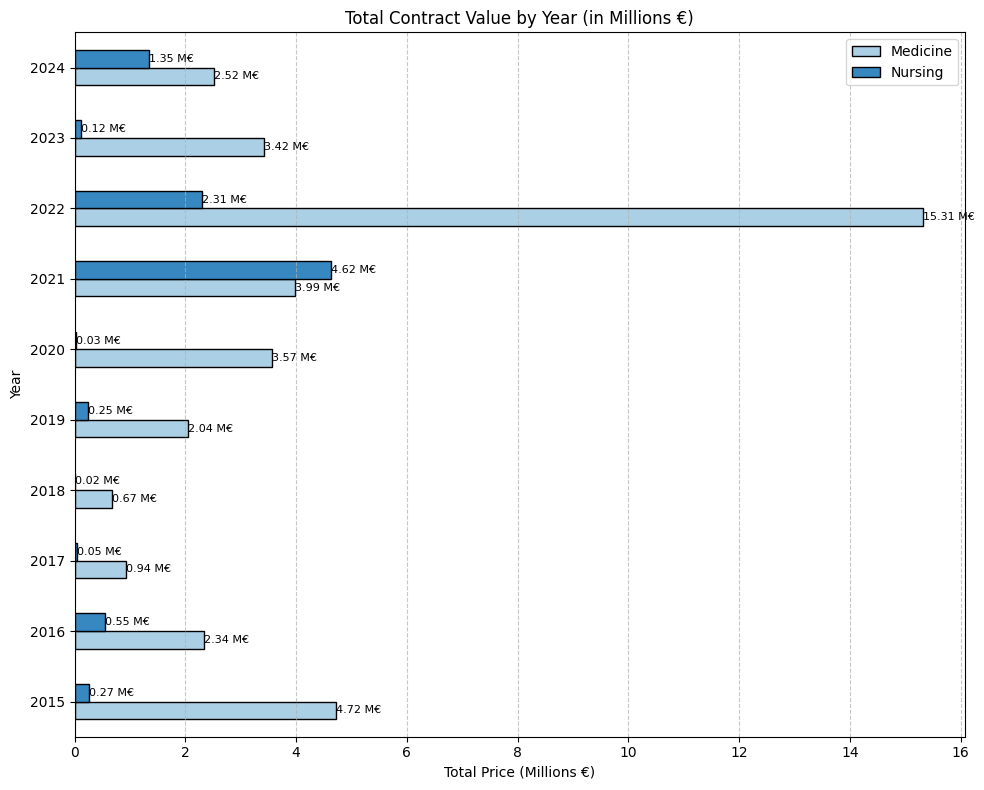

In [120]:
# Plot
fig, ax = plt.subplots(figsize=(10, 8))  # Taller for horizontal
df_totals.plot(kind='barh', 
               stacked=False, 
               color=sns.color_palette('Blues', n_colors=2), 
               edgecolor='black',
               ax=ax)

ax.set_title('Total Contract Value by Year (in Millions €)')
ax.set_xlabel('Total Price (Millions €)')
ax.set_ylabel('Year')
ax.grid(axis='x', linestyle='--', alpha=0.7)

# Anotar valores nas barras
for container in ax.containers:
    for bar in container:
        width = bar.get_width()
        if width > 0:
            ax.annotate(f'{width:,.2f} M€',
                        xy=(width, bar.get_y() + bar.get_height() / 2),
                        ha='left', va='center',
                        fontsize=8)

plt.tight_layout()
plt.show()

# PrazoExecucao

In [121]:
count_null_and_empty(df_geral_contratos_79, 'prazoExecucao')

Null (NaN) values: 0 (0.00%)
Empty string values: 0 (0.00%)


In [122]:
pd.set_option('display.max_colwidth', None)
print(df_geral_contratos_79['prazoExecucao'].head(10))

0    1095
1     325
2     365
3     365
4     365
5     365
6     365
7     365
8     365
9     365
Name: prazoExecucao, dtype: int64


In [123]:
print(df_geral_contratos_79['prazoExecucao'].tail(10))

409    31
410    31
411    28
412    28
413    31
414    31
415    30
416    30
417    31
418    31
Name: prazoExecucao, dtype: int64


In [124]:
print_top_n(df_geral_contratos_79,'prazoExecucao',10)

Top 10 most frequent values for 'prazoExecucao':
prazoExecucao
365    87
366    65
31     30
30     20
60     13
364     8
28      8
90      7
5       6
91      6
Name: count, dtype: int64


In [125]:
print_bottom_n(df_geral_contratos_79,'prazoExecucao',10)

Bottom 10 least frequent values for 'prazoExecucao':
prazoExecucao
308    1
299    1
136    1
324    1
325    1
41     1
2      1
1      1
345    1
39     1
Name: count, dtype: int64


In [126]:
max_prazo_valor = df_geral_contratos_79['prazoExecucao'].max()
print("Maximum 'prazoExecucao (dias)':", max_prazo_valor)
print("Maximum 'prazoExecucao (anos)':", max_prazo_valor/365)
max_rows = df_geral_contratos_79[df_geral_contratos_79['prazoExecucao'] == max_prazo_valor]

Maximum 'prazoExecucao (dias)': 1460
Maximum 'prazoExecucao (anos)': 4.0


In [127]:
top_30_prazos = df_geral_contratos_79['prazoExecucao'].sort_values(ascending=False).head(10)
print("Top 30 highest values for 'prazoExecucao (dias)':")
print(top_30_prazos)

Top 30 highest values for 'prazoExecucao (dias)':
296    1460
306    1096
310    1096
300    1096
207    1095
33     1095
299    1095
205    1095
0      1095
313     731
Name: prazoExecucao, dtype: int64


In [128]:
bottom_30_prazos = df_geral_contratos_79['prazoExecucao'].sort_values(ascending=True).head(10)
print("Top 30 bottom values for 'prazoExecucao (dias)':")
print(bottom_30_prazos)

Top 30 bottom values for 'prazoExecucao (dias)':
257    0
243    0
244    0
230    0
282    0
280    0
153    1
177    2
197    4
367    5
Name: prazoExecucao, dtype: int64


In [129]:
step = 30
bins = list(np.arange(0, max_prazo_valor + step, step))
bins[-1] = np.inf  # Set the last bin to cover all values above the last real edge
labels = [f"{int(bins[i])}-{int(bins[i+1]-1)} dias" if not np.isinf(bins[i+1]) else f"{int(bins[i])}+ dias"
          for i in range(len(bins)-1)]
df_geral_contratos_79['prazoExecucaoIntervalo'] = pd.cut(df_geral_contratos_79['prazoExecucao'], bins=bins, labels=labels)
# Count the occurrences in each interval
count_by_interval = df_geral_contratos_79['prazoExecucaoIntervalo'].value_counts().sort_index()
# Display the counts
count_gt_one = count_by_interval[count_by_interval > 1]
# Display the filtered counts
print(count_gt_one)

prazoExecucaoIntervalo
0-29 dias          44
30-59 dias         49
60-89 dias         26
90-119 dias        17
120-149 dias       12
150-179 dias       11
180-209 dias       10
210-239 dias       16
240-269 dias       16
270-299 dias       12
300-329 dias       13
330-359 dias       10
360-389 dias      160
660-689 dias        4
720-749 dias        2
1080-1109 dias      8
Name: count, dtype: int64


In [130]:
print(df_geral_contratos_79[['prazoExecucao', 'prazoExecucaoIntervalo']].head(20))

    prazoExecucao prazoExecucaoIntervalo
0            1095         1080-1109 dias
1             325           300-329 dias
2             365           360-389 dias
3             365           360-389 dias
4             365           360-389 dias
5             365           360-389 dias
6             365           360-389 dias
7             365           360-389 dias
8             365           360-389 dias
9             365           360-389 dias
10            365           360-389 dias
11            365           360-389 dias
12            365           360-389 dias
13            365           360-389 dias
14             30              0-29 dias
15             30              0-29 dias
16             30              0-29 dias
17            365           360-389 dias
18            365           360-389 dias
19            366           360-389 dias


# Medicine and Nursing by year (with the execution time)

In [131]:
data_medicin = {year: 0 for year in range(2015, 2026)}
data_nursing = {year: 0 for year in range(2015, 2026)}

In [132]:
df_medicine['prazoExecucao'] = pd.to_numeric(df_medicine['prazoExecucao'], errors='coerce')
df_nursing['prazoExecucao'] = pd.to_numeric(df_nursing['prazoExecucao'], errors='coerce')

# Define the bins and labels
bins = [0, 367, 733, 1100, 1470, 1850, float('inf')]
labels = [1, 2, 3, 4, 5, 6]

# Apply binning and convert to int
df_medicine['anos_execucao'] = pd.cut(
    df_medicine['prazoExecucao'],
    bins=bins,
    labels=labels,
    right=False
).astype(int)

df_nursing['anos_execucao'] = pd.cut(
    df_nursing['prazoExecucao'],
    bins=bins,
    labels=labels,
    right=False
).astype(int)

In [133]:
distributed_medicine = 0
for _, row in df_medicine.iterrows():
    ano_inicio = row['Ano']
    anos_exec = row['anos_execucao']
    valor_total = row['precoContratual']
    if pd.notna(ano_inicio) and pd.notna(anos_exec) and anos_exec > 0:
        distributed_medicine += valor_total  # sum before splitting

distributed_nursing = 0
for _, row in df_nursing.iterrows():
    ano_inicio = row['Ano']
    anos_exec = row['anos_execucao']
    valor_total = row['precoContratual']
    if pd.notna(ano_inicio) and pd.notna(anos_exec) and anos_exec > 0:
        distributed_nursing += valor_total

print("Full sum medicine (chart1):", sum_medicine_full)
print("Sum included in distribution logic medicine (should match if none dropped):", distributed_medicine)
print("Full sum nursing (chart1):", sum_nursing_full)
print("Sum included in distribution logic nursing:", distributed_nursing)

Full sum medicine (chart1): 39525455.91
Sum included in distribution logic medicine (should match if none dropped): 39525455.90999997
Full sum nursing (chart1): 9556207.39
Sum included in distribution logic nursing: 9556207.39


In [134]:
top_30_prazos = df_medicine['anos_execucao'].sort_values(ascending=False).head(10)
print("Top 30 highest values for 'anos_execucao - medicine':")
print(top_30_prazos)

Top 30 highest values for 'anos_execucao - medicine':
296    4
0      3
310    3
33     3
343    2
342    2
360    2
345    2
286    2
313    2
Name: anos_execucao, dtype: int64


In [135]:
bottom_30_prazos = df_medicine['anos_execucao'].sort_values(ascending=True).head(10)
print("Top 30 bottom values for 'anos_execucao - medicine':")
print(bottom_30_prazos)

Top 30 bottom values for 'anos_execucao - medicine':
415    1
396    1
397    1
398    1
399    1
400    1
401    1
402    1
403    1
404    1
Name: anos_execucao, dtype: int64


In [136]:
top_30_prazos = df_nursing['anos_execucao'].sort_values(ascending=False).head(10)
print("Top 30 highest values for 'anos_execucao - nursing':")
print(top_30_prazos)

Top 30 highest values for 'anos_execucao - nursing':
300    3
299    3
205    3
306    3
207    3
19     1
21     1
20     1
27     1
28     1
Name: anos_execucao, dtype: int64


In [137]:
bottom_30_prazos = df_nursing['anos_execucao'].sort_values(ascending=True).head(10)
print("Top 30 bottom values for 'anos_execucao - nursing':")
print(bottom_30_prazos)

Top 30 bottom values for 'anos_execucao - nursing':
19    1
20    1
21    1
22    1
23    1
24    1
25    1
26    1
27    1
28    1
Name: anos_execucao, dtype: int64


In [138]:
for _, row in df_medicine.iterrows():
    ano_inicio = int(row['Ano'])
    anos_exec = int(row['anos_execucao'])
    valor_total = row['precoContratual']
    
    if pd.notna(ano_inicio) and pd.notna(anos_exec) and anos_exec > 0:
        valor_anual = valor_total / anos_exec
        for i in range(anos_exec):
            ano = ano_inicio + i
            if ano in data_medicin:
                data_medicin[ano] += valor_anual

In [139]:
for _, row in df_nursing.iterrows():
    ano_inicio = int(row['Ano'])
    anos_exec = int(row['anos_execucao'])
    valor_total = row['precoContratual']
    
    if pd.notna(ano_inicio) and pd.notna(anos_exec) and anos_exec > 0:
        valor_anual = valor_total / anos_exec
        for i in range(anos_exec):
            ano = ano_inicio + i
            if ano in data_nursing:
                data_nursing[ano] += valor_anual

In [140]:
print(data_medicin)

{2015: 4686198.026666667, 2016: 2353156.9566666665, 2017: 956069.8666666667, 2018: 668029.76, 2019: 2034765.9699999997, 2020: 3184794.8600000003, 2021: 4383898.06, 2022: 5291647.930000001, 2023: 5980838.08, 2024: 6769371.090000001, 2025: 3216685.31}


In [141]:
print(data_nursing)

{2015: 267782.6400000001, 2016: 551679.7299999997, 2017: 45996.8, 2018: 17160.0, 2019: 230991.98, 2020: 37003.65, 2021: 4629680.95, 2022: 2177893.2399999998, 2023: 185695.44, 2024: 1412322.96, 2025: 0}


In [142]:
total_medicine = sum(data_medicin.values())
total_nursing = sum(data_nursing.values())

print(f"Total distribuído (Medicine): €{total_medicine:,.2f}")
print(f"Total distribuído (Nursing):  €{total_nursing:,.2f}")


Total distribuído (Medicine): €39,525,455.91
Total distribuído (Nursing):  €9,556,207.39


In [143]:
df_execucao_dist = pd.DataFrame({
    'Medicine': pd.Series(data_medicin),
    'Nursing': pd.Series(data_nursing)
}).fillna(0).sort_index()
df_execucao_dist_m = df_execucao_dist / 1_000_000

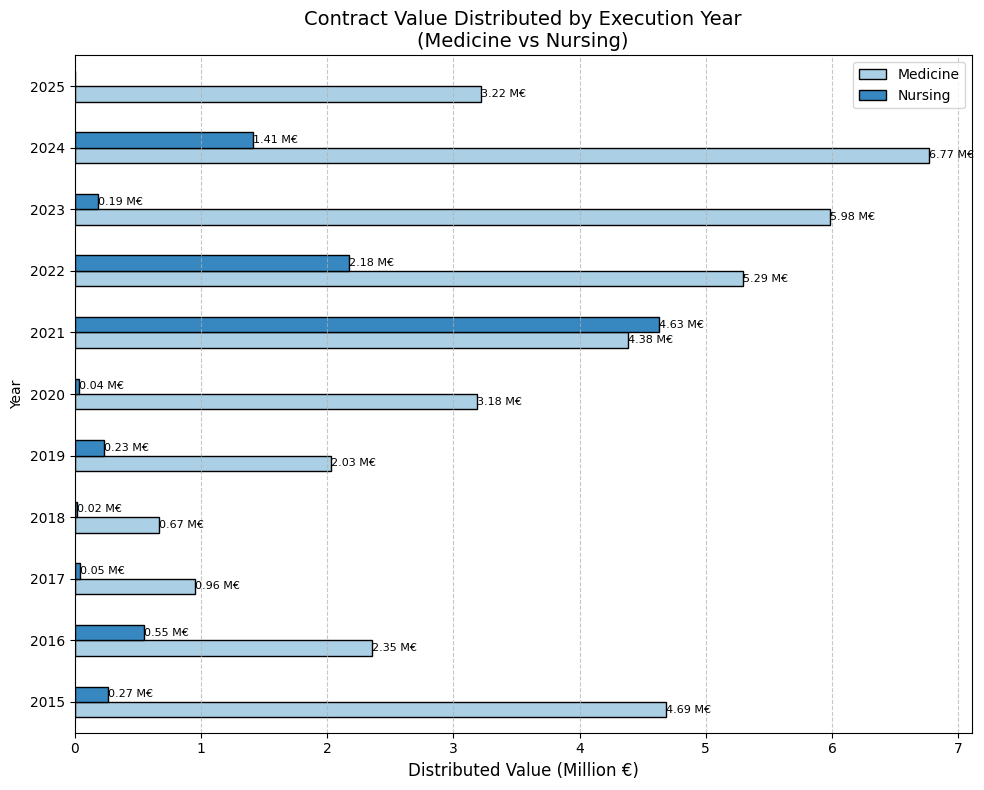

In [144]:
fig, ax = plt.subplots(figsize=(10, 8))
df_execucao_dist_m.plot(kind='barh',
                      stacked=False,
                      color=sns.color_palette('Blues', n_colors=2),
                      edgecolor='black',
                      ax=ax)

ax.set_title('Contract Value Distributed by Execution Year\n(Medicine vs Nursing)', fontsize=14)
ax.set_xlabel('Distributed Value (Million €)', fontsize=12)
ax.set_ylabel('Year')
ax.grid(axis='x', linestyle='--', alpha=0.7)

# Anotar os valores nas barras
for container in ax.containers:
    for bar in container:
        width = bar.get_width()
        if width > 0:
            ax.annotate(f'{width:,.2f} M€',
                        xy=(width, bar.get_y() + bar.get_height() / 2),
                        va='center', ha='left',
                        fontsize=8)

plt.tight_layout()
plt.show()